# BIG DATA AND DATA MINING ASSESSMENT JUPYTER FILE
# STUDENT NAME: AMAECHI UGWUMBA CHRISANGELO
## Student No: 202250330

## To answer the question in  the analysis, i choose to query the database for the data required to anwser each question. The reason for this choice to is to avoid cleaning data that i dont need to answer a particular question and also to test my database query skills.

## IMPORTING THE LIBRARIES NEEDED FOR THE ANALYSIS

In [1]:
# General libraries
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std
%matplotlib inline
sns.set(font_scale=1.1)

# Importing libraries for appriori analysis
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# For Exploratory Data Analysis
from ydata_profiling import ProfileReport

# Importing libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
## For clustering plot using live map
import folium


# Outlier Detection libraries
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Sklearn libraries for classifications and including variable selectors
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                                ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection  import train_test_split



# Suppress DeprecationWarnings from specific modules
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Some seeborn plot seeting
sns.set(font_scale=1.2)
sns.set_style('white')

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\visions\utils\monkeypatches\imghdr_patch.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  from imghdr import tests
C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


# ESTABLISHING CONNECTION WITH MY DATABASE

In [2]:
# Connecting the the Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")

# Creating the cursor to point to the database
cur = con.cursor()

# Question 1:Are there significant hours of the day and days of the week on which accidents occur?

## For this question i will querry the accident table of the database to get the time and days of the weeks that accidents happen and get the most frequent

In [3]:
# Selecting all the columns in the dataset and storing the results of to a pandas dataframe
acc_frequency = pd.read_sql_query("""
SELECT accident_index, accident_year, day_of_week, time FROM accident
WHERE accident.accident_year = 2020 """, con)
acc_frequency

accident_index  accident_year  day_of_week   time
0      2020010219808           2020            3  09:00
1      2020010220496           2020            2  13:55
2      2020010228005           2020            4  01:25
3      2020010228006           2020            4  01:50
4      2020010228011           2020            4  02:25
...              ...            ...          ...    ...
91194  2020991027064           2020            4  14:30
91195  2020991029573           2020            6  15:05
91196  2020991030297           2020            4  12:42
91197  2020991030900           2020            3  14:00
91198  2020991032575           2020            3  13:50

[91199 rows x 4 columns]

## Exploratory data analysis: Checking for missing values in the data

In [4]:
# Checking for Missing Values
acc_frequency.isna().sum()

accident_index    0
accident_year     0
day_of_week       0
time              0
dtype: int64

### Running pandas data profiling to explore if any more abnormality exist in the dataset

In [5]:
# Pandas data profiling
profile = ProfileReport(acc_frequency, minimal=True)
profile

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\profile_report.py:489: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\report\presentation\flavours\widget\correlation_table.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\report\presentation\flavours\widget\duplicate.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\sit

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Preprocessing of the dataframe 
## Defining a function the takes the time column and convert them to hourly time range of the format "00:00-00-59" 

In [6]:
# Function to convert the time in minutes so as to create group the time in intervals of two hours

def hours_time_group(time):
    # convert the hour and minutes into one whole time in minutes
    hours, minutes = map(int, time.split(':'))
    total_minutes = hours * 60 + minutes
    
    # Defining the various time interval; ie creating the twelve distict groups of 2 hours per group
    int_length = 24*60//24
    int_start = (total_minutes // int_length) * int_length
    int_end = int_start + int_length - 1
    
    int_start_hr = int_start //60
    int_start_min = int_start % 60
    int_end_hr = int_end //60
    int_end_min = int_end % 60
    # returning the 12 groups with the start hour:minute and the end hour:minute
    return f"{int_start_hr:02d}:{int_start_min:02d} - {int_end_hr:02d}:{int_end_min:02d}"
    

## Defining a function that takes the new time-range column, preprocessing it and plotting the results of the time accidents happens by hours 

In [7]:


def accident_plots_by_time_interval(acc_frequency, plot_title):
    # Applying the "two_hours_time_group" function to the time column of our motorcycle dataframe
    acc_frequency["time_range"] = acc_frequency["time"].apply(hours_time_group)

    # Checking the first 5 rows of the  new data to confirm that the "time_range column has been added"
    print(acc_frequency.head())
    # Calculate the value counts of the "time_range" column
    time_group = acc_frequency["time_range"].value_counts().sort_index()

    # Convert the count value into a DataFrame
    time_df = pd.DataFrame({"Total Count": time_group})

    # Change the index name of the DataFrame
    time_df.index.names = ["Time Intervals"]
    time_df.reset_index(inplace=True)

    # Create the plot
    fig = plt.figure(figsize=(10, 8))
    time_interval_plot = sns.barplot(data=time_df, y='Time Intervals', x="Total Count")
    time_interval_plot.set(title=plot_title)  # Set the plot title dynamically
    time_interval_plot.set_xticklabels(time_interval_plot.get_xticklabels(), rotation=45)
    # calculating the percentage of accidents by time period for the plot
    t_total = time_df['Total Count'].sum()
    for p in time_interval_plot.patches:
        percentage = '{:.1f}%'.format((p.get_width() / t_total) * 100)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        time_interval_plot.annotate(percentage, (x, y))
    time_interval_plot.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.savefig(f"{plot_title.replace(' ', '_')}_plot.png")
    plt.show()

## Passing the acc_frequency table to the "hours_time_group" function, and then passing the new "time_range" column to the "accident_plots_by_time_interval" function

  accident_index  accident_year  day_of_week   time     time_range
0  2020010219808           2020            3  09:00  09:00 - 09:59
1  2020010220496           2020            2  13:55  13:00 - 13:59
2  2020010228005           2020            4  01:25  01:00 - 01:59
3  2020010228006           2020            4  01:50  01:00 - 01:59
4  2020010228011           2020            4  02:25  02:00 - 02:59


C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\569415709.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  time_interval_plot.set_xticklabels(time_interval_plot.get_xticklabels(), rotation=45)


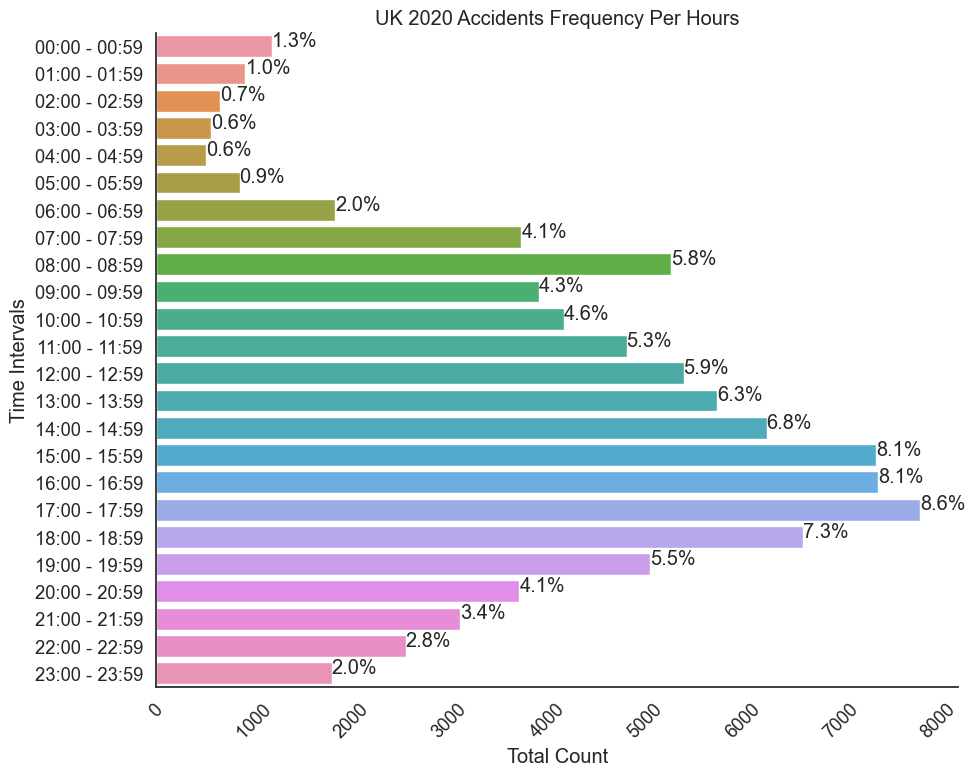

In [8]:
# Calling the calling the above function on the acc_frequency table
accident_plots_by_time_interval(acc_frequency, "UK 2020 Accidents Frequency Per Hours")

## FOR ACCIDENTS BY DAY OF THE WEEK
## The function below takes the day of the weak accident occur and return a plot of the cuntvalues

In [9]:
def daily_accident_freq(acc_frequency, plot_title):
    # Taking a value count of the number of accidents that fall within the given days of the week range
    day_group = acc_frequency["day_of_week"].value_counts().sort_index()

    # converting the count value into a dataframe and giving the values a column name of "Total Count"
    day_df = pd.DataFrame({"Total Count": day_group})

    # Changing the index name of the dataframe to "Time Intervals"
    day_df.index.names =["Day Intervals"]
    day_df.reset_index(inplace=True)

    # Adding a new column to the day_df reflect the real value of the or the label of 1-7
    day_df["Day_of_Week"] = ["Sun", "Mon", "Tue", "Wed", "Thur", "Fri", "Sat"]
    # Viewing the the 
    print(day_df)
    
    
    #Plotting the results of the days accidents happen
    day_interval_plot = sns.barplot(data = day_df, x='Day_of_Week', y="Total Count")
    day_interval_plot.set(title = plot_title)
    day_interval_plot.set_xticklabels(day_interval_plot.get_xticklabels())
    
    # Calculate and display percentages
    d_total = day_df['Total Count'].sum()
    for p in day_interval_plot.patches:
        percentage = '{:.1f}%'.format((p.get_height() / d_total) * 100)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        day_interval_plot.annotate(percentage, (x, y), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f"{plot_title.replace(' ', '_')}_plot.png")
    plt.show()
    


   Day Intervals  Total Count Day_of_Week
0              1        10315         Sun
1              2        12772         Mon
2              3        13267         Tue
3              4        13564         Wed
4              5        14056        Thur
5              6        14889         Fri
6              7        12336         Sat


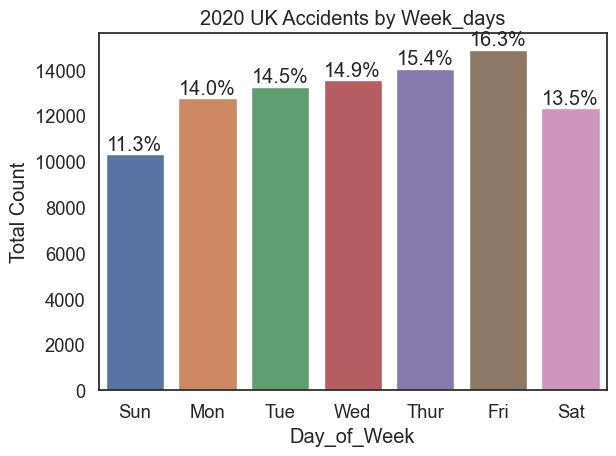

In [10]:
daily_accident_freq(acc_frequency, "2020 UK Accidents by Week_days")

# QUESTION 2: For Motorbikes, are there significant hours of the day and days of the week on which accidents occur with focus on

## Motorcycle 125cc and under, Motorcycle pcer 125cc and up to 500cc and  Motorcycle over 500cc

## For this question i will query the accident table for time and day_of_Week and the vahivleType columen of vehivle table where vehicle_type = , 3, 4, and 5

In [11]:
 
# Selecting all the columns in the dataset and storing the results of to a pandas dataframe
Motorcycle_acc_freq = pd.read_sql_query("""
SELECT vehicle_index, time, day_of_week, vehicle_type FROM accident
JOIN vehicle ON accident.accident_index = vehicle.accident_index
WHERE vehicle.accident_year = 2020 
AND 
(
 vehicle_type= 3
OR vehicle_type= 4
OR vehicle_type= 5
)
""", con)
Motorcycle_acc_freq

vehicle_index   time  day_of_week  vehicle_type
0             681728  03:25            4             3
1             681749  14:00            4             3
2             681752  14:37            4             3
3             681774  19:05            4             3
4             681793  14:29            4             3
...              ...    ...          ...           ...
12993         848911  16:30            5             3
12994         849008  17:30            4             3
12995         849017  17:55            2             3
12996         849020  15:45            5             4
12997         849087  12:42            4             5

[12998 rows x 4 columns]

## Passing the Motorcycle dataframe to the "accident_plots_by_time_interval "and daily_accident_freq" functions

## For the time that Motorcycles are most involved in accidents we get

   vehicle_index   time  day_of_week  vehicle_type     time_range
0         681728  03:25            4             3  03:00 - 03:59
1         681749  14:00            4             3  14:00 - 14:59
2         681752  14:37            4             3  14:00 - 14:59
3         681774  19:05            4             3  19:00 - 19:59
4         681793  14:29            4             3  14:00 - 14:59


C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\569415709.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  time_interval_plot.set_xticklabels(time_interval_plot.get_xticklabels(), rotation=45)


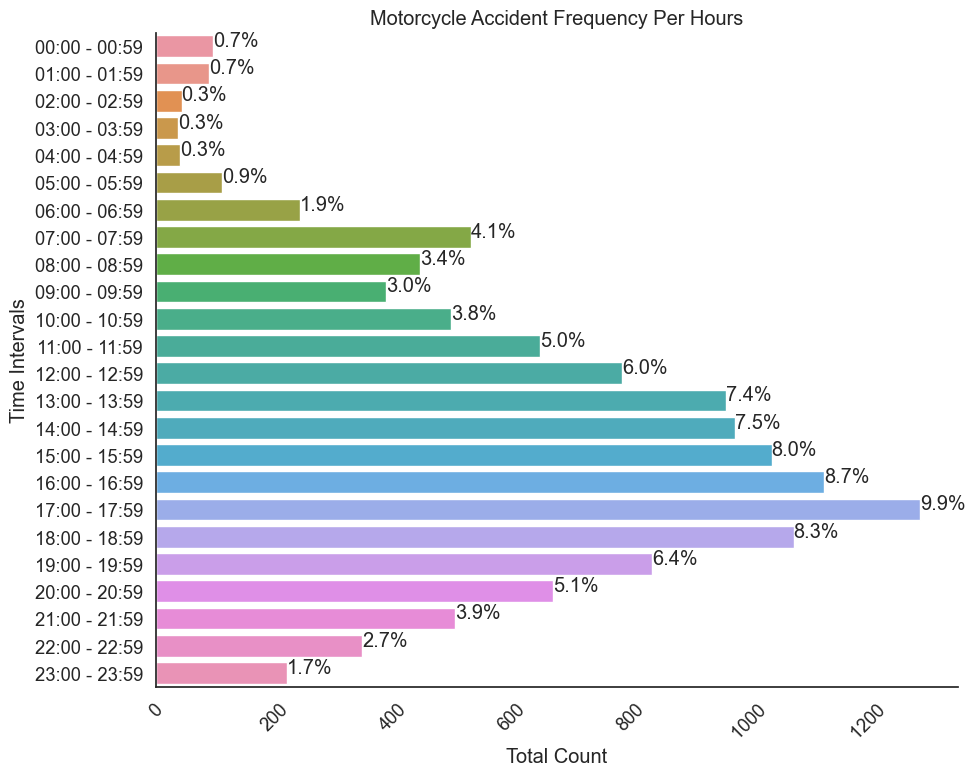

In [12]:
# Calling the calling the above function on the acc_frequency table
accident_plots_by_time_interval(Motorcycle_acc_freq, "Motorcycle Accident Frequency Per Hours")

## The rate at which each type of motercycle is involved in an accident  wit respect to time is given in the table below

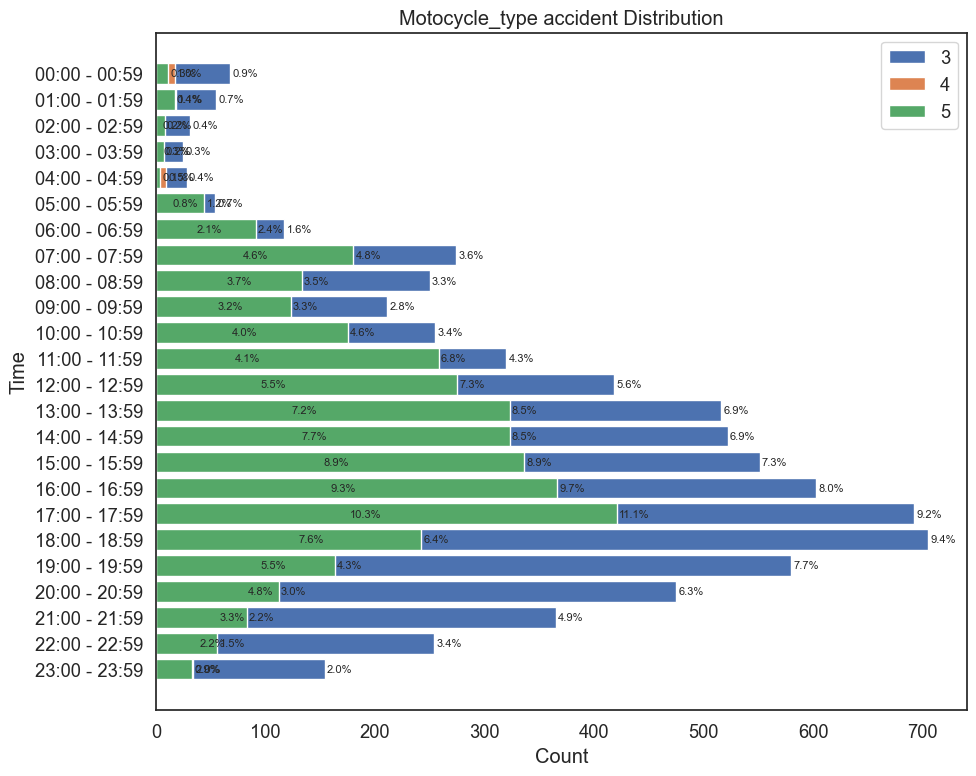

In [13]:


# Group by 'vehicle_type' and count occurrences of each time value
grouped = Motorcycle_acc_freq.groupby('vehicle_type')['time_range'].value_counts()

# Plot a horizontal bar plot for each unique vehicle_type
plt.figure(figsize=(10, 8))
for vehicle_type in Motorcycle_acc_freq['vehicle_type'].unique():
    counts = grouped[vehicle_type].sort_index(ascending =False)
    total_count = counts.sum()
    percentages = (counts / total_count) * 100  # Calculate percentages
    plt.barh(counts.index, counts.values, label=vehicle_type)  # Use barh for horizontal plot
    
    # Add percentage values next to each bar
    for i, count in enumerate(counts.values):
        plt.text(count + 2, i, f'{percentages[i]:.1f}%', va='center', fontsize=8)

plt.ylabel('Time')
plt.xlabel('Count')
plt.title('Motocycle_type accident Distribution')
plt.legend()
plt.tight_layout()
plt.savefig("Vehicle_types_plot1")
plt.show()


## For the days of the week that motorcycles are most involved in accidents

   Day Intervals  Total Count Day_of_Week
0              1         1738         Sun
1              2         1703         Mon
2              3         1765         Tue
3              4         1841         Wed
4              5         2002        Thur
5              6         2119         Fri
6              7         1830         Sat


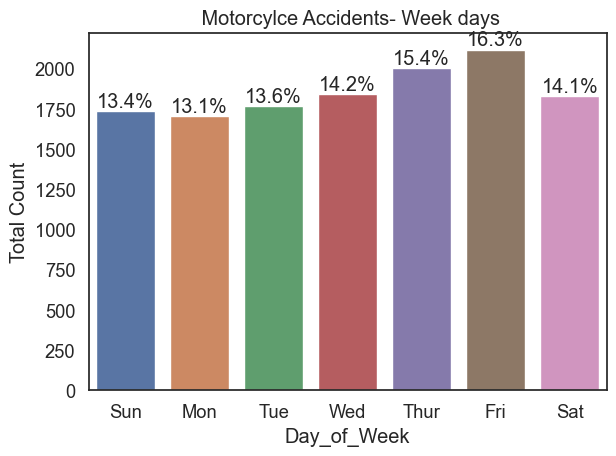

In [14]:
daily_accident_freq(Motorcycle_acc_freq, " Motorcylce Accidents- Week days")

## The rate at which each type of motercycle is involved in an accident  witt respect to day_of_week is given in the table below

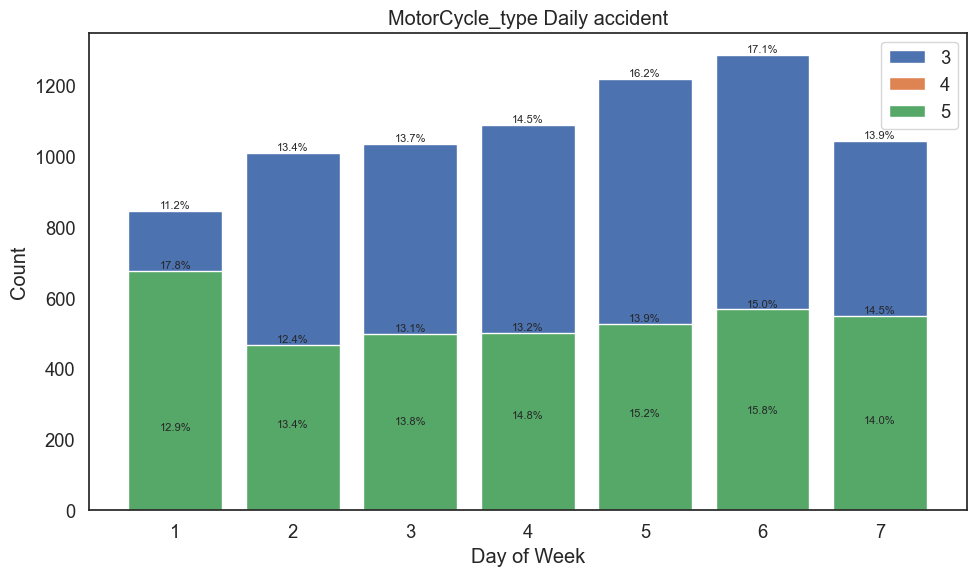

In [15]:

# Group by 'vehicle_type' and count occurrences of each day_of_week value
grouped = Motorcycle_acc_freq.groupby("vehicle_type")["day_of_week"].value_counts()

# Plot a vertical bar plot for each unique vehicle_type
plt.figure(figsize=(10, 6))
for vehicle_type in Motorcycle_acc_freq["vehicle_type"].unique():
    counts = grouped[vehicle_type].sort_index()
    total_count = counts.sum()
    percentages = (counts / total_count) * 100  # Calculate percentages
    
    # Filter out days of the week that are not present in the current vehicle type's data
    valid_days = counts.index
    plt.bar(valid_days, counts.values, label=vehicle_type)  # Use bar for vertical plot
    
    # Add percentage values above each bar
    for day in valid_days:
        count = counts[day]
        percentage = percentages[day]
        plt.text(day, count + 2, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=8)

plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.title("MotorCycle_type Daily accident")
plt.legend()
plt.tight_layout()
plt.savefig("MotorCycle_type Daily accident")

plt.show()


## Below is the percentage of each motocycle involved in accidents ins in 2020

In [16]:
#Percentage of each motocylce_type involvement in accident
Motorcycle_acc_freq["vehicle_type"].value_counts(normalize=True) * 100

3    57.878135
5    29.112171
4    13.009694
Name: vehicle_type, dtype: float64

# QUESTION 3: For Pedestrians involved in accident, are there significant hours of the day and days of the week onn whic the are more likely to be involved
## For this i will query the database for Time, day_of_week and the casualty table for casualty_class = 3 representing Pedestrains

In [17]:
# Selecting all the columns in the dataset and storing the results of to a pandas dataframe
Pedestrain_acc_freq = pd.read_sql_query("""
SELECT casualty_index, day_of_week, time, age_band_of_casualty, casualty_class FROM accident
JOIN casualty on accident.accident_index = casualty.accident_index
WHERE accident.accident_year = 2020
AND
casualty_class ==3""", con)
Pedestrain_acc_freq

casualty_index  day_of_week   time  age_band_of_casualty  \
0              484748            3  09:00                     6   
1              484749            2  13:55                     1   
2              484750            2  13:55                     1   
3              484751            4  01:25                     5   
4              484752            4  01:50                     8   
...               ...          ...    ...                   ...   
14745          600321            3  10:30                     8   
14746          600322            2  17:00                     9   
14747          600326            3  12:00                    10   
14748          600328            6  15:05                     9   
14749          600331            3  13:50                     8   

       casualty_class  
0                   3  
1                   3  
2                   3  
3                   3  
4                   3  
...               ...  
14745               3  
14746               3  
14747               3  
14748               3  
14749               3  

[14750 rows x 5 columns]

## Passing the Pedestrain dataframe to the "accident_plots_by_time_interval "and daily_accident_freq" functions

## For the time that Pedestrains are most involved in accidents we get

   casualty_index  day_of_week   time  age_band_of_casualty  casualty_class  \
0          484748            3  09:00                     6               3   
1          484749            2  13:55                     1               3   
2          484750            2  13:55                     1               3   
3          484751            4  01:25                     5               3   
4          484752            4  01:50                     8               3   

      time_range  
0  09:00 - 09:59  
1  13:00 - 13:59  
2  13:00 - 13:59  
3  01:00 - 01:59  
4  01:00 - 01:59  


C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\569415709.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  time_interval_plot.set_xticklabels(time_interval_plot.get_xticklabels(), rotation=45)


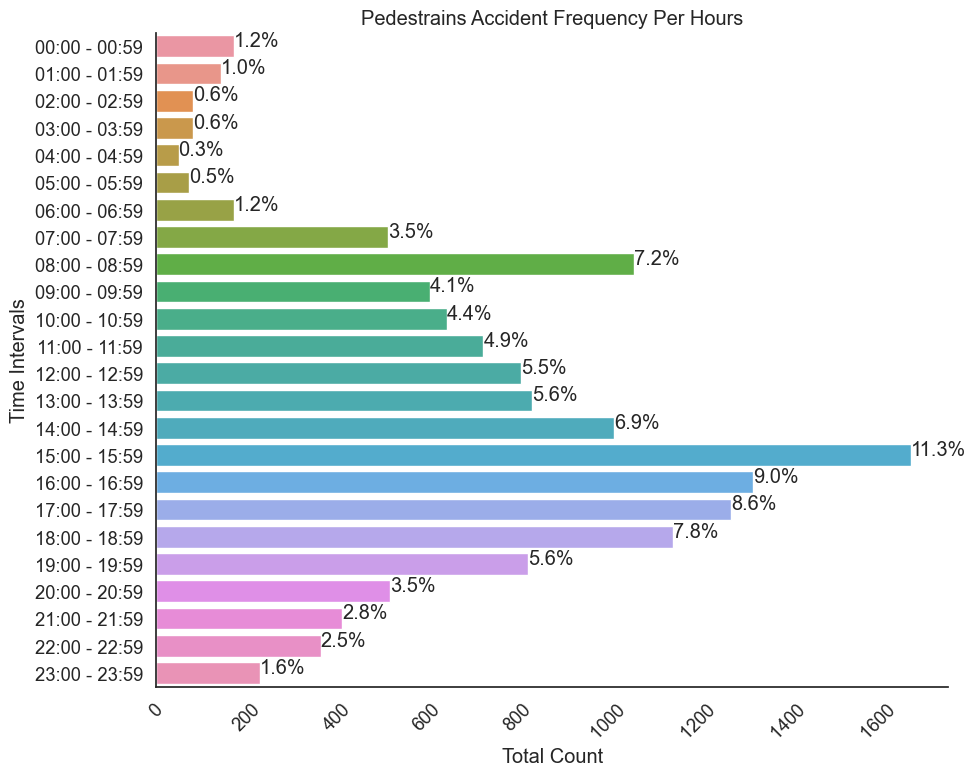

In [18]:
# Calling the calling the above function on the acc_frequency table
accident_plots_by_time_interval(Pedestrain_acc_freq, "Pedestrains Accident Frequency Per Hours")

## There is a shift in the hours when accidents occur the must. To Better understand this, i will use a plot of the age_band_of_casualty value counts

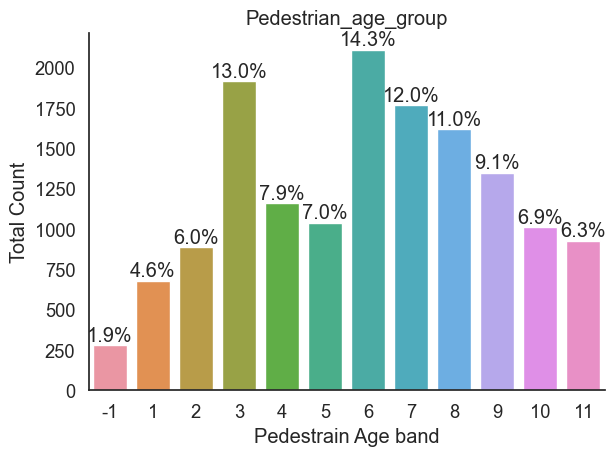

In [19]:
# Taking a value count of the number of accidents that fall within the given time range
Pedestrian_age_group = Pedestrain_acc_freq["age_band_of_casualty"].value_counts().sort_index()

# converting the count value into a dataframe and giving the values a column name of "Total Count"
Pedestrian_age_df = pd.DataFrame({"Total Count": Pedestrian_age_group})

# Changing the index name of the dataframe to "Time Intervals"
Pedestrian_age_df.index.names =["Pedestrain Age band"]
Pedestrian_age_df.reset_index(inplace = True)
Pedestrian_age_df

 #Plotting the results of the days accidents happen
Pedestrian_age_group_plot = sns.barplot(data = Pedestrian_age_df, x='Pedestrain Age band', y="Total Count")
Pedestrian_age_group_plot.set(title = "Pedestrian_age_group")
Pedestrian_age_group_plot.set_xticklabels(Pedestrian_age_group_plot.get_xticklabels())
    
# Calculate and display percentages
Pedestrian_age_df_total = Pedestrian_age_df['Total Count'].sum()
for p in Pedestrian_age_group_plot.patches:
    percentage = '{:.1f}%'.format((p.get_height() / Pedestrian_age_df_total) * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    Pedestrian_age_group_plot.annotate(percentage, (x, y), ha='center', va='bottom')
Pedestrian_age_group_plot.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig(f"Age_band_of Casualty")
plt.show()

### The above plot shows that the column 3( 11-15year) has a witnessed a significant increase at 8 in the number and 3 in the afternoon likely representing when the go to school or when they are returning from school

## For the day of the week that padestrains are most involved in accidents

   Day Intervals  Total Count Day_of_Week
0              1         1242         Sun
1              2         2207         Mon
2              3         2267         Tue
3              4         2247         Wed
4              5         2366        Thur
5              6         2543         Fri
6              7         1878         Sat


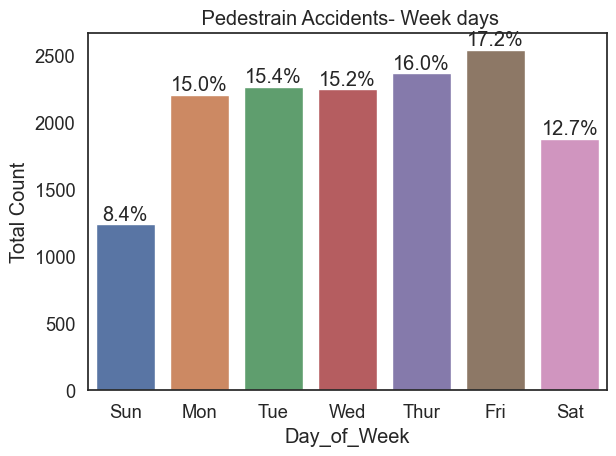

In [20]:
daily_accident_freq(Pedestrain_acc_freq, " Pedestrain Accidents- Week days")

# QUESTION 4: Using Apriori Algorithm, explore the impact of selected varaibles on accident severity

## There are lots of numerical columns in the dataset and as such, i will use human intuition to select 10 variables  that i believe can significantly inpact the severity of accidents and the result of the querry is given below

In [21]:
### Because of the high number of avariables in the dataset, intuitively i will select about 10 of the variables that my human intuition can aduce to impact the likelihood of an accident or  the severity of an accident.

apriori_df = pd.read_sql_query("""
SELECT accident.accident_index, accident_severity,  second_road_class, junction_location, road_type, speed_limit, weather_conditions, road_surface_conditions, light_conditions, urban_or_rural_area, casualty_class, sex_of_driver FROM accident
JOIN vehicle on accident.accident_index = vehicle.accident_index
JOIN casualty on accident.accident_index = casualty.accident_index 
WHERE accident.accident_year = 2020 """, con)
apriori_df

accident_index  accident_severity  second_road_class  \
0       2020010219808                  3                  0   
1       2020010220496                  3                  6   
2       2020010220496                  3                  6   
3       2020010228005                  3                  6   
4       2020010228006                  2                  0   
...               ...                ...                ...   
220430  2020991030297                  2                  6   
220431  2020991030297                  2                  6   
220432  2020991030900                  3                  6   
220433  2020991030900                  3                  6   
220434  2020991032575                  3                  0   

        junction_location  road_type  speed_limit  weather_conditions  \
0                       0          6           20                   9   
1                       2          6           20                   1   
2                       2          6           20                   1   
3                       0          6           30                   1   
4                       0          6           30                   1   
...                   ...        ...          ...                 ...   
220430                  6          6           60                   1   
220431                  1          6           60                   1   
220432                  6          6           30                   1   
220433                  8          6           30                   1   
220434                  0          6           30                   1   

        road_surface_conditions  light_conditions  urban_or_rural_area  \
0                             9                 1                    1   
1                             1                 1                    1   
2                             1                 1                    1   
3                             2                 4                    1   
4                             1                 4                    1   
...                         ...               ...                  ...   
220430                        1                 1                    2   
220431                        1                 1                    2   
220432                        1                 1                    1   
220433                        1                 1                    1   
220434                        1                 1                    1   

        casualty_class  sex_of_driver  
0                    3              2  
1                    3              1  
2                    3              1  
3                    3              3  
4                    3              1  
...                ...            ...  
220430               1              1  
220431               1              1  
220432               1              2  
220433               1              1  
220434               3              1  

[220435 rows x 12 columns]

## The total number of rows from this column (220435) is greater than the total number of rows in the accident table(91199) meaning that some accident_index has been duplicated where we have more than one casualty or vehicle involved in an accident

## Defining a fucntion that returns only one unique accident entry, 

In [22]:
def unique_accident(dataf, unique_column_name):
    # Find all the rows where the unique_column_name is duplicated. 
    find_duplicated_rows = dataf.duplicated(subset = unique_column_name, keep ="first")
    
    # Filter and return not_duplicated rows and the first of the duplicated rows
    unique_rows = dataf[~find_duplicated_rows]
    
    # Drop all Objects from the dataframe
    
    accident_df = unique_rows.select_dtypes(exclude=["object"])
    
    return accident_df

apriori_df = unique_accident(apriori_df, "accident_index")

## For the percentage of each accident_severity in the dataset, we get

In [23]:
# Percentage of each accident severity in the dataset
apriori_df["accident_severity"].value_counts(normalize=True) * 100

3    78.348447
2    20.126317
1     1.525236
Name: accident_severity, dtype: float64

In [24]:
apriori_df

accident_severity  second_road_class  junction_location  road_type  \
0                       3                  0                  0          6   
1                       3                  6                  2          6   
3                       3                  6                  0          6   
4                       2                  0                  0          6   
5                       3                  5                  1          6   
...                   ...                ...                ...        ...   
220427                  2                  4                  3          6   
220429                  3                  6                  1          9   
220430                  2                  6                  6          6   
220432                  3                  6                  6          6   
220434                  3                  0                  0          6   

        speed_limit  weather_conditions  road_surface_conditions  \
0                20                   9                        9   
1                20                   1                        1   
3                30                   1                        2   
4                30                   1                        1   
5                30                   1                        1   
...             ...                 ...                      ...   
220427           30                   1                        1   
220429           30                   1                        1   
220430           60                   1                        1   
220432           30                   1                        1   
220434           30                   1                        1   

        light_conditions  urban_or_rural_area  casualty_class  sex_of_driver  
0                      1                    1               3              2  
1                      1                    1               3              1  
3                      4                    1               3              3  
4                      4                    1               3              1  
5                      4                    1               3              1  
...                  ...                  ...             ...            ...  
220427                 1                    1               1              1  
220429                 1                    1               3              2  
220430                 1                    2               1              1  
220432                 1                    1               1              2  
220434                 1                    1               3              1  

[91199 rows x 11 columns]

## The function below checks for missing value as well as pandas dataprofiling. 

## Note that  the pandas data profiling will stop displaying when i close my jupyter notebook and as such i will include a report of the data profiling as a html file in the submitted files

In [25]:
def exploratory_analysis(df):
    print(df.isna().sum())
    #Using pandas profiling
    profile1 = ProfileReport(df, minimal=True)
    return profile1

In [26]:
# Exploratory Data Analysis
exploratory_analysis(apriori_df)


accident_severity          0
second_road_class          0
junction_location          0
road_type                  0
speed_limit                0
weather_conditions         0
road_surface_conditions    0
light_conditions           0
urban_or_rural_area        0
casualty_class             0
sex_of_driver              0
dtype: int64


C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\profile_report.py:489: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### From the exploratory analysis, some of the ables have -1 entries which represent entries where the data is missing: Calculating the number of -1 in each column of the dataset

In [27]:
def contains_negative_one(df):
    neg_one_columns = []
    for column in df.columns:
        if -1 in df[column].values:
            neg_one_columns.append(column)
    return neg_one_columns

In [28]:
#The columns that have -1 values in them
contains_negative_one(apriori_df)

['second_road_class',
 'junction_location',
 'speed_limit',
 'weather_conditions',
 'road_surface_conditions',
 'light_conditions',
 'sex_of_driver']


## I first exploy the effect of dummy values = -1 and the effect it will have on the entire dataset if i drop all rows where the -1 value appear
## I decide not to drop the -1 here because ssince we are doing rule mining, if the number of -1 does not meet the minimum thresold values, the rule will not pic them

In [29]:
## Converting the apriori table to dummy values we get
apriori_df1 =pd.get_dummies(apriori_df, columns = apriori_df.columns)

# Displaying the new apriori tables with dummy values
apriori_df1

accident_severity_1  accident_severity_2  accident_severity_3  \
0                         0                    0                    1   
1                         0                    0                    1   
3                         0                    0                    1   
4                         0                    1                    0   
5                         0                    0                    1   
...                     ...                  ...                  ...   
220427                    0                    1                    0   
220429                    0                    0                    1   
220430                    0                    1                    0   
220432                    0                    0                    1   
220434                    0                    0                    1   

        second_road_class_-1  second_road_class_0  second_road_class_1  \
0                          0                    1                    0   
1                          0                    0                    0   
3                          0                    0                    0   
4                          0                    1                    0   
5                          0                    0                    0   
...                      ...                  ...                  ...   
220427                     0                    0                    0   
220429                     0                    0                    0   
220430                     0                    0                    0   
220432                     0                    0                    0   
220434                     0                    1                    0   

        second_road_class_2  second_road_class_3  second_road_class_4  \
0                         0                    0                    0   
1                         0                    0                    0   
3                         0                    0                    0   
4                         0                    0                    0   
5                         0                    0                    0   
...                     ...                  ...                  ...   
220427                    0                    0                    1   
220429                    0                    0                    0   
220430                    0                    0                    0   
220432                    0                    0                    0   
220434                    0                    0                    0   

        second_road_class_5  ...  urban_or_rural_area_1  \
0                         0  ...                      1   
1                         0  ...                      1   
3                         0  ...                      1   
4                         0  ...                      1   
5                         1  ...                      1   
...                     ...  ...                    ...   
220427                    0  ...                      1   
220429                    0  ...                      1   
220430                    0  ...                      0   
220432                    0  ...                      1   
220434                    0  ...                      1   

        urban_or_rural_area_2  urban_or_rural_area_3  casualty_class_1  \
0                           0                      0                 0   
1                           0                      0                 0   
3                           0                      0                 0   
4                           0                      0                 0   
5                           0                      0                 0   
...                       ...                    ...               ...   
220427                      0                      0                 1   
220429                      0                      0            

## Defining the apriori model with a minimum threshold of 0.2 we get

In [30]:
# defining the condition for the frequency item sets
frequency_itemsets = apriori(apriori_df1, min_support=0.2, use_colnames = True)
frequency_itemsets["length"] = frequency_itemsets["itemsets"].apply(lambda x: len(x))
frequency_itemsets

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets  length
0    0.201263                              (accident_severity_2)       1
1    0.783484                              (accident_severity_3)       1
2    0.415882                              (second_road_class_0)       1
3    0.399511                              (second_road_class_6)       1
4    0.416529                              (junction_location_0)       1
..        ...                                                ...     ...
495  0.200748  (weather_conditions_1, urban_or_rural_area_1, ...       6
496  0.205770  (light_conditions_1, weather_conditions_1, urb...       6
497  0.215792  (light_conditions_1, weather_conditions_1, urb...       6
498  0.207513  (light_conditions_1, weather_conditions_1, acc...       6
499  0.205068  (light_conditions_1, weather_conditions_1, urb...       6

[500 rows x 3 columns]

## I will use lift >1 as the metrics to evaluate my apriori with min_threshold for support and confidence as 0.2 and 0.8 respectivly

In [31]:
# Using lift and the metrics to determine the rules in my item
rules = association_rules(frequency_itemsets, metric = "lift", min_threshold=1.02)

# Calculating the total number of antecedents and ading it to the dataframe as antecedent_len column
rules["antecedents_len"] = rules["antecedents"].apply(lambda x:len(x))

# Establishing the limit of support and confidence min_threshould for my analysis
Final_rules = rules[(rules["consequents"]== {"accident_severity_3"}) & (rules["support"] > 0.3) & (rules["confidence"] >0.8)]

# subsetting the Final_rules column for the relevant columns for my analysis
Final_rules1 = Final_rules[["antecedents_len", "antecedents", "consequents", "support", "confidence", "lift"]]

# printing out my final result on the screen
Final_rules1

antecedents_len                                        antecedents  \
2                  1                                   (speed_limit_30)   
5                  1                            (urban_or_rural_area_1)   
90                 2               (road_type_6, urban_or_rural_area_1)   
96                 2        (road_surface_conditions_1, speed_limit_30)   
102                2               (light_conditions_1, speed_limit_30)   
107                2            (speed_limit_30, urban_or_rural_area_1)   
112                2                 (casualty_class_1, speed_limit_30)   
123                2      (weather_conditions_1, urban_or_rural_area_1)   
131                2  (road_surface_conditions_1, urban_or_rural_are...   
137                2        (light_conditions_1, urban_or_rural_area_1)   
140                2          (casualty_class_1, urban_or_rural_area_1)   
752                3  (road_surface_conditions_1, weather_conditions...   
781                3  (weather_conditions_1, speed_limit_30, urban_o...   
891                3  (road_surface_conditions_1, weather_conditions...   
921                3  (light_conditions_1, weather_conditions_1, urb...   
946                3  (casualty_class_1, weather_conditions_1, urban...   
961                3  (road_surface_conditions_1, light_conditions_1...   

               consequents   support  confidence      lift  
2    (accident_severity_3)  0.459983    0.802717  1.024548  
5    (accident_severity_3)  0.550313    0.812932  1.037586  
90   (accident_severity_3)  0.400114    0.802119  1.023784  
96   (accident_severity_3)  0.327021    0.802756  1.024598  
102  (accident_severity_3)  0.330409    0.812736  1.037335  
107  (accident_severity_3)  0.396463    0.807292  1.030387  
112  (accident_severity_3)  0.346133    0.819794  1.046344  
123  (accident_severity_3)  0.425827    0.807599  1.030778  
131  (accident_severity_3)  0.391594    0.812324  1.036809  
137  (accident_severity_3)  0.389379    0.822280  1.049517  
140  (accident_severity_3)  0.416912    0.831191  1.060890  
752  (accident_severity_3)  0.306012    0.801010  1.022369  
781  (accident_severity_3)  0.308984    0.803187  1.025147  
891  (accident_severity_3)  0.364456    0.809755  1.033530  
921  (accident_severity_3)  0.317262    0.815180  1.040455  
946  (accident_severity_3)  0.324291    0.823335  1.050863  
961  (accident_severity_3)  0.302141    0.818360  1.044513

In [32]:
# Converting the above to a web table to view all the antecedents
styled_df = Final_rules1.style.applymap(lambda x: 'background-color: white')

# Save the styled DataFrame to an HTML file
styled_df.to_html('styled_table.html')

# QUESTION 5: Identify Accidents within "Humberside". Perform Clustering on this dataset

## There are the Shires within Humberside consisting of "Kigston upon Hull", "East Riding of Yorkshire", "North Linconlshire", and "North East Lincolnshire"

## The police authority designation number for Humberside is 16

In [33]:
# For this question, i will query the database for accidents in "Kingston Upon Hul", "Humberside", and "East Riding of Yorkshire
Humberside_df = pd.read_sql_query("""
SELECT * FROM accident
JOIN vehicle on accident.accident_index = vehicle.accident_index
JOIN casualty on accident.accident_index = casualty.accident_index 
JOIN lsoa on accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE accident.accident_year = 2020 
AND
police_force = 16
""", con)
len(Humberside_df)

3985

## Understanding accidents distribution by Location Humberside

In [34]:
# Checking for missing values on the dataset
Humberside_df.isna().sum()

accident_index            0
accident_year             0
accident_reference        0
location_easting_osgr     0
location_northing_osgr    0
                         ..
lsoa01nm                  0
lsoa01nmw                 0
shape__area               0
shape__length             0
globalid                  0
Length: 90, dtype: int64

### Since location(longitude and Latitude) is the main focus of this clustering exercise to understant the distribution of where accidents coocure the most we will perform our clustering on them

In [35]:
# location dataset for East of YorkShire
Humberside_cluster_df = Humberside_df[["longitude", "latitude"]]

# Converting the dataset to a nympy array
Humberside_cluster_df = Humberside_cluster_df.copy().to_numpy()

# Viewing the numpy array
Humberside_cluster_df

array([[-0.393424, 53.744936],
       [-0.393424, 53.744936],
       [-0.528743, 53.512895],
       ...,
       [-0.703181, 53.569801],
       [-0.342063, 53.742609],
       [-0.342063, 53.742609]])

## Calculating the optimum number of clusters for Kmeans and Kmedoid CLustering

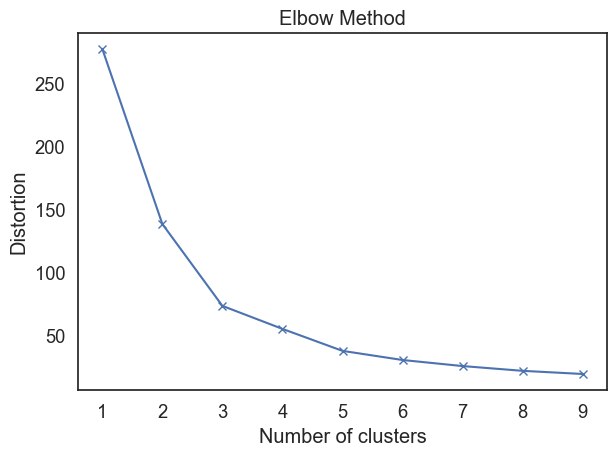

In [36]:
# Usining kmeans and the elbowe  method to determine the optimum number of clusters

distort = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state= 3, n_init=10)
    kmeans.fit(Humberside_cluster_df)
    distort.append(kmeans.inertia_)


plt.plot(K, distort, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.tight_layout()
plt.savefig("elbow_plot.png")
plt.show()

# Calculating the optimum value of epsilon for DBSCAN

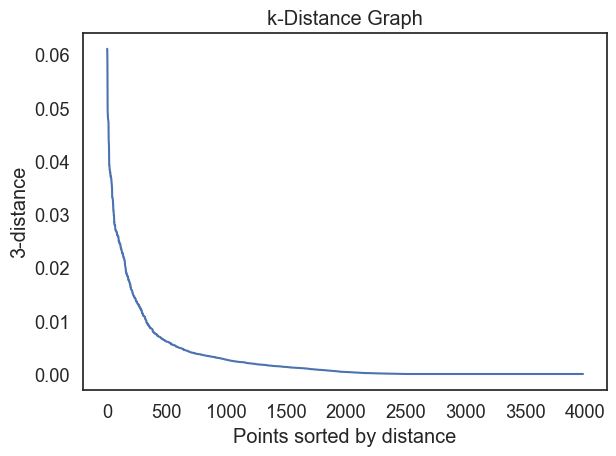

In [37]:
### Defining the optimum value f the epsilon
# Finding the optimum number of esp

k=3
NN = NearestNeighbors(n_neighbors=k+1) 
nbrs = NN.fit(Humberside_cluster_df)
distances, indices = nbrs.kneighbors(Humberside_cluster_df)

# Plotting the epsilon values
sorted_distances = np.sort(distances[:, k], axis=0)[::-1]
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.rcParams["figure.figsize"] = (5,3)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-distance")
plt.title("k-Distance Graph")
plt.tight_layout()
plt.savefig("DBSCAN_kdistance.png")
plt.show()

### From the above two plots, the elbow plot shows that the the optimum number of cluster for the dataset is 5 while the of the k_distnace plot shows the epsilon is 0.2

# Defining a cluster that takes the value dataframe and runs the three clusters above on the dataframe

In [38]:
 # location dataset for East of YorkShire
Humberside_cluster_df = Humberside_df[["longitude", "latitude"]]

In [39]:
def cluster_analysis(X, n_clusters = 5, dbscan_eps = 0.01, dbscan_min_samples = 5, random_state=42):
    # Normalizing the dataset to using numpy array
    normalized_df = Humberside_cluster_df.copy().to_numpy()
    
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(normalized_df)
    kmeans_centers = kmeans.cluster_centers_
    
    # KMedoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state)
    kmedoids_labels = kmedoids.fit_predict(normalized_df)
    kmedoids_centers = normalized_df[kmedoids.medoid_indices_]

    # DBSCAN clustering
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    dbscan_labels = dbscan.fit_predict(normalized_df)
    
    # Compute silhouette scores
    kmeans_silhouette = silhouette_score(normalized_df, kmeans_labels)
    kmedoids_silhouette = silhouette_score(normalized_df, kmedoids_labels)
    dbscan_silhouette = silhouette_score(normalized_df, dbscan_labels)

    # Plotting
    plt.figure(figsize=(18, 5))
    
    # KMeans plot
    plt.subplot(1, 3, 1)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=kmeans_labels, s=10, cmap='viridis')
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='X', s=60, label='Centers')
    plt.title(f'KMeans Clusters (Silhouette: {kmeans_silhouette:.2f})')
    plt.legend
    plt.savefig("Kmeans.png")

    # KMedoids plot
    plt.subplot(1, 3, 2)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=kmedoids_labels, s=10, cmap='viridis')
    plt.scatter(kmedoids_centers[:, 0], kmedoids_centers[:, 1], c='red', marker='X', s=60, label='Medoids')
    plt.title(f'KMedoids Clusters (Silhouette: {kmedoids_silhouette:.2f})')
    plt.legend()
    plt.savefig("Kmedoids.png")

    # DBSCAN plot
    plt.subplot(1, 3, 3)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=dbscan_labels, s=10, cmap='viridis')
    plt.title(f'DBSCAN Clusters (Silhouette: {dbscan_silhouette:.2f})')
    plt.tight_layout()
    plt.savefig("DBSCAN.png")
    plt.show()
    

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


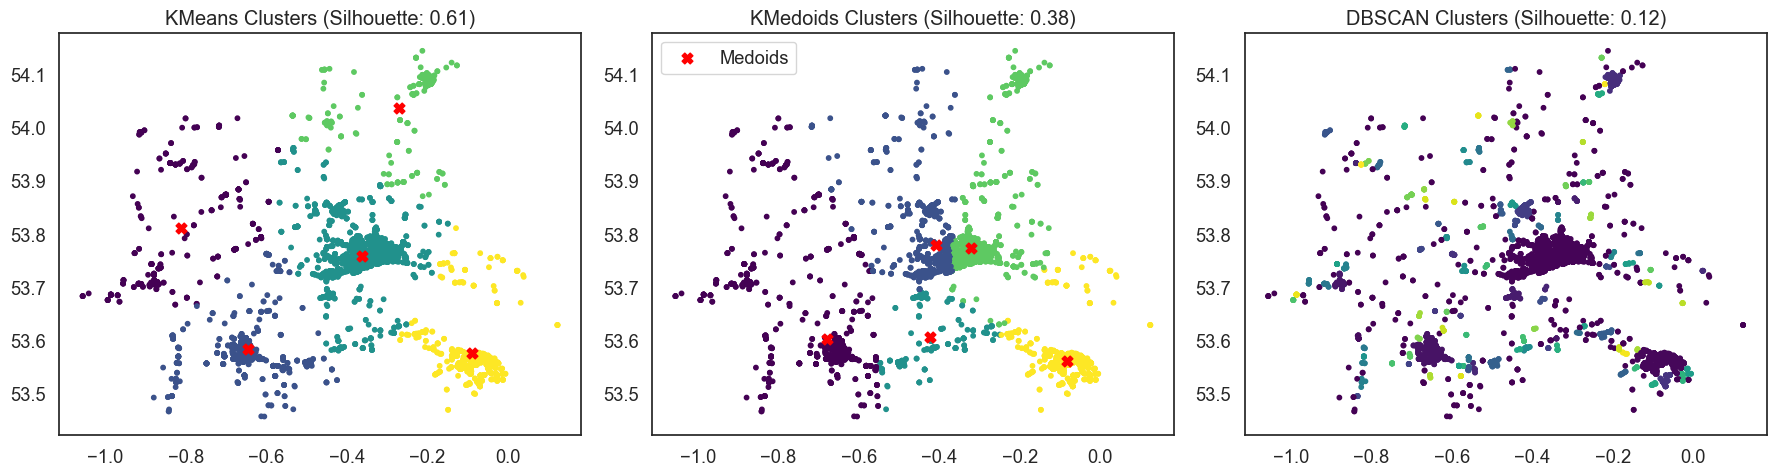

In [40]:
# Calling the cluster function
cluster_analysis(Humberside_cluster_df)

## Plotting the cluster analysis on a real map of Humberside Region

In [41]:


#Making a PLot of Kmeans on the live map of Huberisde

Humberside_coordinates = Humberside_cluster_df.copy()
normalized_df = Humberside_coordinates.copy().to_numpy()
kmeans = KMeans(n_clusters=5, random_state=45)
kmeans_labels = kmeans.fit_predict(normalized_df)
kmeans_centers = kmeans.cluster_centers_
Humberside_coordinates['clusters'] = kmeans_labels

map = folium.Map(location=[53.812524, 0.421276], zoom_start= 10,  title='openstreetmap')



cluster1 = Humberside_coordinates[['latitude', 'longitude']][Humberside_coordinates['clusters'] == 0 ].values.tolist()
cluster2 = Humberside_coordinates[['latitude', 'longitude']][Humberside_coordinates['clusters'] == 1 ].values.tolist()
cluster3 = Humberside_coordinates[['latitude', 'longitude']][Humberside_coordinates['clusters'] == 2 ].values.tolist()
cluster4 = Humberside_coordinates[['latitude', 'longitude']][Humberside_coordinates['clusters'] == 3 ].values.tolist()
cluster5 = Humberside_coordinates[['latitude', 'longitude']][Humberside_coordinates['clusters'] == 4 ].values.tolist()



for cluster in cluster1:
    folium.CircleMarker(cluster, radius= 0.5, color = 'purple').add_to(map)

for cluster in cluster2:
    folium.CircleMarker(cluster, radius= 0.5, color = 'blue').add_to(map)

for cluster in cluster3:
    folium.CircleMarker(cluster, radius= 0.5, color = 'green').add_to(map)

for cluster in cluster4:
    folium.CircleMarker(cluster, radius= 0.5, color = 'lightgreen').add_to(map)

for cluster in cluster5:
    folium.CircleMarker(cluster, radius= 0.5, color = 'yellow').add_to(map)

map

## Using Speed limit and Accident Severity to see if there is any more identifiable parterns in the the dataset using clustering

In [42]:
# location dataset for East of YorkShire
driver_severity_cluster_df = Humberside_df[["speed_limit", "accident_severity"]]
# Converting the dataset to a nympy array
driver_severity_cluster_df = driver_severity_cluster_df.copy().to_numpy()

# Viewing the numpy array
driver_severity_cluster_df

array([[30,  3],
       [30,  3],
       [30,  3],
       ...,
       [70,  3],
       [30,  3],
       [30,  3]], dtype=int64)

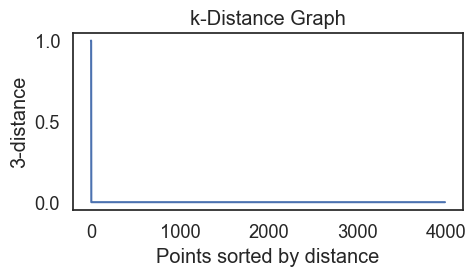

In [43]:
### Defining the optimum value f the epsilon
# Finding the optimum number of esp

k=3
NN = NearestNeighbors(n_neighbors=k+1) 
nbrs = NN.fit(driver_severity_cluster_df)
distances, indices = nbrs.kneighbors(driver_severity_cluster_df)

# Plotting the epsilon values
sorted_distances = np.sort(distances[:, k], axis=0)[::-1]
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.rcParams["figure.figsize"] = (5,3)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-distance")
plt.title("k-Distance Graph")
plt.tight_layout()
plt.savefig("DBSCAN_kdistance.png")
plt.show()

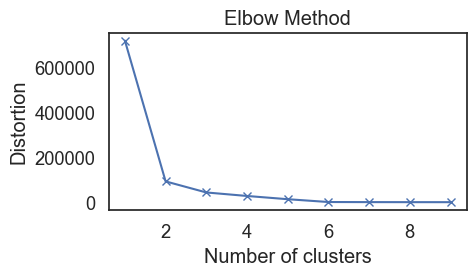

In [44]:
# Usining kmeans and the elbowe  method to determine the optimum number of clusters

distort = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state= 3, n_init=10)
    kmeans.fit(driver_severity_cluster_df)
    distort.append(kmeans.inertia_)


plt.plot(K, distort, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.tight_layout()
plt.savefig("elbow_plot.png")
plt.show()

In [45]:
driver_severity_cluster_df = Humberside_df[["speed_limit", "accident_severity"]]
def cluster_analysis(X, n_clusters = 2, dbscan_eps = 0.01, dbscan_min_samples = 5, random_state=42):
    # Normalizing the dataset to using numpy array
    normalized_df = driver_severity_cluster_df.copy().to_numpy()
    
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(normalized_df)
    kmeans_centers = kmeans.cluster_centers_
    
    # KMedoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state)
    kmedoids_labels = kmedoids.fit_predict(normalized_df)
    kmedoids_centers = normalized_df[kmedoids.medoid_indices_]

    # DBSCAN clustering
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    dbscan_labels = dbscan.fit_predict(normalized_df)
    
    # Compute silhouette scores
#     kmeans_silhouette = silhouette_score(normalized_df, kmeans_labels)
#     kmedoids_silhouette = silhouette_score(normalized_df, kmedoids_labels)
#     dbscan_silhouette = silhouette_score(normalized_df, dbscan_labels)

    # Plotting
    plt.figure(figsize=(18, 5))
    
    # KMeans plot
    plt.subplot(1, 3, 1)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=kmeans_labels, s=10, cmap='viridis')
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='X', s=60, label='Centers')
#     plt.title(f'KMeans Clusters (Silhouette: {kmeans_silhouette:.2f})')
    plt.legend()
    plt.savefig("Kmeans.png")

    # KMedoids plot
    plt.subplot(1, 3, 2)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=kmedoids_labels, s=10, cmap='viridis')
    plt.scatter(kmedoids_centers[:, 0], kmedoids_centers[:, 1], c='red', marker='X', s=60, label='Medoids')
#     plt.title(f'KMedoids Clusters (Silhouette: {kmedoids_silhouette:.2f})')
    plt.legend()
    plt.savefig("Kmedoids.png")

    # DBSCAN plot
    plt.subplot(1, 3, 3)
    plt.scatter(normalized_df[:, 0], normalized_df[:, 1], c=dbscan_labels, s=10, cmap='viridis')
#     plt.title(f'DBSCAN Clusters (Silhouette: {dbscan_silhouette:.2f})')
    plt.tight_layout()
    plt.savefig("DBSCAN.png")
    plt.show()
    

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


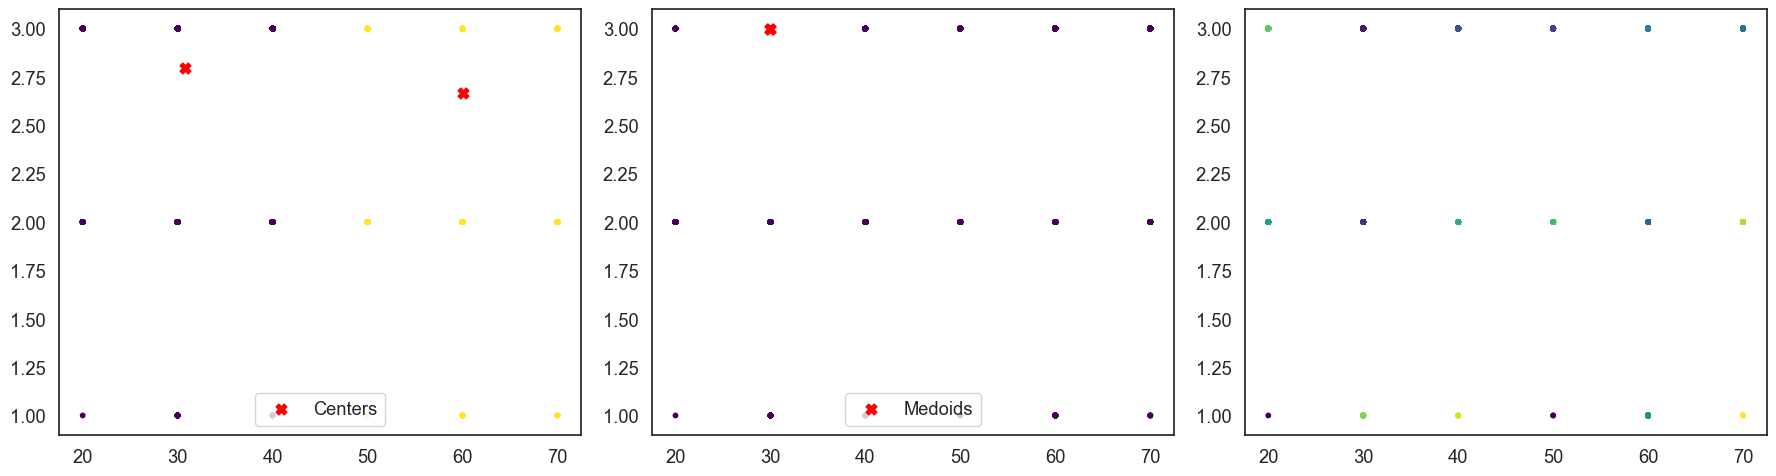

In [46]:
# Calling the cluster function to display the cluster plot
cluster_analysis(driver_severity_cluster_df)

### From the above plot there is no informative clusters between speed limit and accident severity

# QUESTION 6: Using Ourlier Detection methods, identify unusual entries in the dataset. Should we keep these data or remove them from the dataset

## To Anwser This Question, i will use the same location dataset i used on the for East Riding of Yorkshire to answer this question in addition to the "urban_or_rural_area" column since accident is location dependent

In [47]:
Humberside_outlier_df = Humberside_df[["longitude", "latitude", "urban_or_rural_area"]]

## SInce there is no NAN values, i will proceed with the Outlier detection analysis. For this i will use two main outlier detection methods

In [48]:
# Using only the longitude and Latitude for the outlier model
Humberside_outlier = Humberside_df[["longitude", "latitude"]]


C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\2915813709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Humberside_outlier["LOF_Outlier"] = LOF_pred
C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\2915813709.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Humberside_outlier["urban_or_rural_area"] =Humberside_df["urban_or_rural_area"]


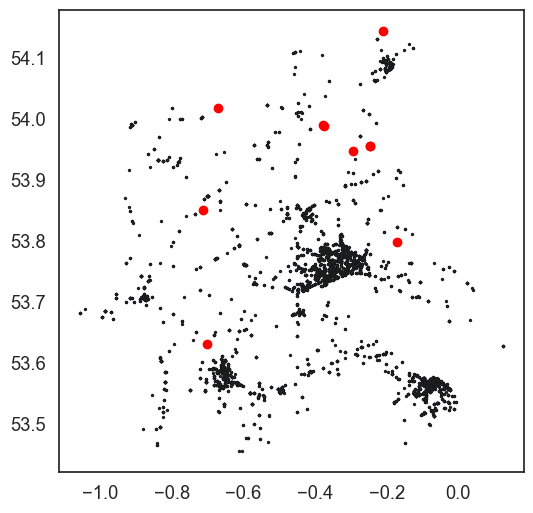

In [49]:
# Building The model
model = LocalOutlierFactor(n_neighbors = 3, contamination = 0.0025)
y_pred = model.fit_predict(Humberside_outlier)
LOF_Scores = model.negative_outlier_factor_
LOF_pred= pd.Series(y_pred).replace([-1,1], [1,0])
Humberside_outlier["LOF_Outlier"] = LOF_pred
LOF_anomalies = Humberside_outlier[LOF_pred==1]
"""
To better understand if we there are outlies that we should drop, we can match the match the locations where the column
"urban_or_rural_area"== 1 and the IF_Outliers ==1. If we superimpose this locations on the plot of the outlier detection
and If there are still outliers within the densily located accident location, thi will be considered an outlier because its 
"urban_or_rural_area" 2 and represents rural area. This can be changed to 1 but we should not drop it because its actually a 
real accident location
"""
Humberside_outlier["urban_or_rural_area"] =Humberside_df["urban_or_rural_area"]
Humberside_outlier_URA = Humberside_outlier[["longitude", "latitude","urban_or_rural_area","LOF_Outlier" ]]
mismatch1 = Humberside_outlier_URA[(Humberside_outlier_URA["LOF_Outlier"]==1) &  (Humberside_outlier_URA["urban_or_rural_area"]==1)]

# Plotting the model to show the ourliers
plt.figure(figsize=(6,6))
plt.scatter(Humberside_outlier["longitude"], Humberside_outlier["latitude"], s=2,edgecolor="k" )
plt.scatter(LOF_anomalies["longitude"], LOF_anomalies["latitude"], c="red")
plt.scatter(mismatch1["longitude"], mismatch1["latitude"], c="blue")

plt.savefig("LOF_outlier.png")

In [50]:
# Subsetting the rows where we have outliers i get
Humberside_outlier[Humberside_outlier["LOF_Outlier"]==1]

longitude   latitude  LOF_Outlier  urban_or_rural_area
189   -0.211803  54.143923            1                    2
543   -0.377446  53.989354            1                    2
884   -0.171261  53.798403            1                    2
1048  -0.294368  53.947359            1                    2
1694  -0.702865  53.631506            1                    2
2375  -0.671258  54.017211            1                    2
2376  -0.245593  53.956014            1                    2
2377  -0.245593  53.956014            1                    2
2994  -0.375659  53.987847            1                    2
3447  -0.712512  53.849891            1                    2

## Exploring the outliers to identify if the are within the urban or rural area to aim our recommendation

# Using the Isolation Forest
### Soliation forest uses only numbers in its analysis

In [51]:
Humberside_outlier2 = Humberside_df.select_dtypes(include=np.number)

In [52]:
# Defining the random sample question
ranst = np.random.RandomState(0)

# Building the outlier Detection model
model = IsolationForest(max_samples = 100, random_state=ranst,contamination=0.01)
model.fit(Humberside_outlier2)
if_scores = model.decision_function(Humberside_outlier2)
if_anomalies = model.predict(Humberside_outlier2)
if_anomalies = pd.Series(if_anomalies).replace([-1,1],[1,0])
Humberside_outlier2['IF_Outliers'] = if_anomalies
if_anomalies =Humberside_outlier2[if_anomalies==1]
if_anomalies

"""
To better understand if we there are outlies that we should drop, we can match the match the locations where the column
"urban_or_rural_area"== 1 and the IF_Outliers ==1. If we superimpose this locations on the plot of the outlier detection
and If there are still outliers within the densily located accident location, thi will be considered an outlier because its 
"urban_or_rural_area" 2 and represents rural area. This can be changed to 1 but we should not drop it because its actually a 
real accident location

"""
Humberside_outlier2_URA = Humberside_outlier2[["longitude", "latitude","urban_or_rural_area","IF_Outliers" ]]
Outliers_df = Humberside_outlier2_URA[Humberside_outlier2_URA["IF_Outliers"]==1]
Humberside_outlier2_URA[Humberside_outlier2_URA["IF_Outliers"]==1].value_counts().sum()
mismatch2 = Humberside_outlier2_URA[(Humberside_outlier2_URA["IF_Outliers"]==1) &  (Humberside_outlier2_URA["urban_or_rural_area"]==1)]

C:\Users\AMAECHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


## Plotting the outliers on map of humberside to based on their rural and urban area values
### this reason for this is because i have decided not to drop the the ouliers because they are actual recorded accidents and using this method i can evaluate if they are urban_rural_area designation was accurately recorded

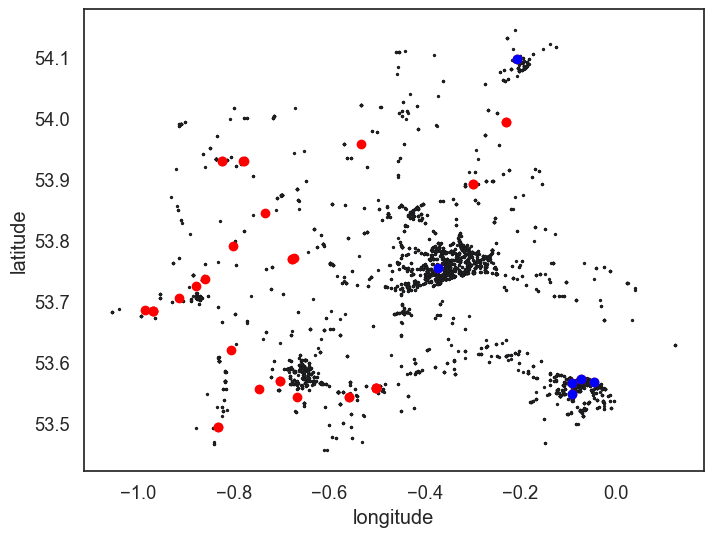

In [53]:
# Plotting the outlier detection function
plt.figure(figsize=(8,6))
plt.scatter(Humberside_outlier2["longitude"], Humberside_outlier2["latitude"], s=2,edgecolor="k" )
plt.scatter(if_anomalies["longitude"], if_anomalies["latitude"], c="red")
plt.scatter(mismatch2["longitude"], mismatch2["latitude"], c="blue")
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.savefig("IF_outlier.png")

## Rows to change their urban_or_rural_area_values based on their row index

In [54]:
# Outliers row change
Outliers_change = Outliers_df[(Outliers_df["longitude"].between(-0.705, -0.6)) & (Outliers_df["latitude"].between(53.5, 53.6))]
Outliers_change= Outliers_change.drop_duplicates()
Outliers_change

longitude   latitude  urban_or_rural_area  IF_Outliers
2614  -0.667506  53.543080                    2            1
3980  -0.703181  53.569801                    2            1

## To change their "urband_or_rural_area" using their indexes we get

In [55]:
## To change their urband and rural area using their indexes we get
indexes_to_change = [2614, 3980]  # Indices of the rows you want to change

for index in indexes_to_change:
    Humberside_outlier_df.at[index, 'urban_or_rural_area'] = 1

## Repeating the plot on using a real map of the humberside we get.

In [56]:
# center_map = [53.812524, 0.421276]
# humberS_map = folium.Map(location= center_map, zoom_start = 10)


# for i, row in Outliers_df.iterrows():
#     color = "red" if row["urban_or_rural_area"] == 1 else "blue"
    
#     folium.Marker(location = [row["latitude"], row["longitude"]], icon = folium.Icon(color =color),).add_to(humberS_map)
    
# humberS_map

# QUESTION 7: Classification of fatality.

## For the classification query, i will query the dataset to return only the distinct values of reccorded accident. the reason for this is because the total number of accidents recorded is 91199 while the recorded vehicle and casualty tables are well over this figure and joining them without forcing the forcing the querry to return only distict accidents will result on repeated accident index rows becasue an accident can involve more than one vehicle and can result in multiple casualties 


## To classify fatality i use the accident_severity column, I detailed working and arrangement of the data cleaning process will also be documented here

## Data: For this exercise, i will query the database for all the columns in the accident, vehicle and casualty columns. The lsoa table is ommited because most of the columns in this table are objects which are normally excluded from classification

In [57]:
# Select the columns from the accident, vehicle and casualty tables where the accident_year = 2020
df = pd.read_sql_query("""SELECT * FROM accident
    INNER JOIN vehicle on accident.accident_index = vehicle.accident_index
    LEFT JOIN casualty on vehicle.accident_index = casualty.accident_index WHERE accident.accident_year = 2020""", con)
# Print or display the content of the dataframe
df

accident_index  accident_year accident_reference  \
0       2020010219808           2020          010219808   
1       2020010220496           2020          010220496   
2       2020010220496           2020          010220496   
3       2020010228005           2020          010228005   
4       2020010228006           2020          010228006   
...               ...            ...                ...   
220430  2020991030297           2020          991030297   
220431  2020991030297           2020          991030297   
220432  2020991030900           2020          991030900   
220433  2020991030900           2020          991030900   
220434  2020991032575           2020          991032575   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    529337.0                176237.0  -0.139253  51.470327   
2                    529337.0                176237.0  -0.139253  51.470327   
3                    526432.0                182761.0  -0.178719  51.529614   
4                    538676.0                184371.0  -0.001683  51.541210   
...                       ...                     ...        ...        ...   
220430               383664.0                810646.0  -2.271903  57.186317   
220431               383664.0                810646.0  -2.271903  57.186317   
220432               277161.0                674852.0  -3.968753  55.950940   
220433               277161.0                674852.0  -3.968753  55.950940   
220434               240402.0                681950.0  -4.561040  56.003843   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   1  ...   
1                  1                  3                   1  ...   
2                  1                  3                   1  ...   
3                  1                  3                   1  ...   
4                  1                  2                   1  ...   
...              ...                ...                 ...  ...   
220430            99                  2                   2  ...   
220431            99                  2                   2  ...   
220432            99                  3                   2  ...   
220433            99                  3                   2  ...   
220434            99                  3                   1  ...   

        age_band_of_casualty casualty_severity  pedestrian_location  \
0                          6                 3                    9   
1                          1                 3                    1   
2                          1                 3                    1   
3                          5                 3                    5   
4                          8                 2                    4   
...                      ...               ...                  ...   
220430                     7                 2                    0   
220431                     7                 2                    0   
220432                    11                 3                    0   
220433                    11                 3                    0   
220434                     8                 3                    9   

       pedestrian_movement  car_passenger bus_or_coach_passenger  \
0                        5              0                      0   
1                        1              0                      0   
2                        1              0                      0   
3                        9              0                      0   
4                        1              0                      0   
...                    ...            ...                    ...   
220430                   0              0                      0   
220431                   0              0                      0   
220432                   0              0                      0   

## There are 220435 rows in the dataframe and but the accident table has 91199 rows meaning accident has been duplicated because of the join query. The reaseon being that a every accident has a unique identifies "accident_index" and every unique accident can involve more than one vehicle or more than one casualty, Thus when we join the tables accident_index is diplicated because of the multiple casuaties and vehicles they reference.

## To resolve this we need to get all the rows where they are unique entries for the "accident_index" column.

# DETAILED DATA CLEANING AND EXPLORATION

## First find all the duplicated columns in the dataframe and dropping them

In [58]:
# Checking if there are duplicated columns
full_df_dup = df.loc[:, df.columns.duplicated()]
print(full_df_dup.head())


# Dropping all duplicated columns
df = df.loc[:, ~df.columns.duplicated()]

  accident_index  accident_year accident_reference accident_index  \
0  2020010219808           2020          010219808  2020010219808   
1  2020010220496           2020          010220496  2020010220496   
2  2020010220496           2020          010220496  2020010220496   
3  2020010228005           2020          010228005  2020010228005   
4  2020010228006           2020          010228006  2020010228006   

   accident_year accident_reference  vehicle_reference  
0           2020          010219808                  1  
1           2020          010220496                  1  
2           2020          010220496                  1  
3           2020          010228005                  1  
4           2020          010228006                  1  


## The function below takes the dataframe and returns the rows where accident_index columns value is unique and then drop all objects in the dataframe

In [59]:
def unique_accident(dataf, unique_column_name):
    # Find all the rows where the unique_column_name is duplicated. 
    find_duplicated_rows = dataf.duplicated(subset = unique_column_name, keep ="first")
    
    # Filter and return not_duplicated rows and the first of the duplicated rows
    unique_rows = df[~find_duplicated_rows]
    
    # Drop all Objects from the dataframe
    
    accident_df = unique_rows.select_dtypes(exclude=["object"])
    
    return accident_df
    
    
    

## Applying the unique_accident function to the dataframe and with the accident_index as target column

In [60]:
# Applying the function
unique_col = "accident_index"
df = unique_accident(df,unique_col)
df

accident_year  location_easting_osgr  location_northing_osgr  \
0                2020               521389.0                175144.0   
1                2020               529337.0                176237.0   
3                2020               526432.0                182761.0   
4                2020               538676.0                184371.0   
5                2020               529324.0                181286.0   
...               ...                    ...                     ...   
220427           2020               343034.0                731654.0   
220429           2020               257963.0                658891.0   
220430           2020               383664.0                810646.0   
220432           2020               277161.0                674852.0   
220434           2020               240402.0                681950.0   

        longitude   latitude  police_force  accident_severity  \
0       -0.254001  51.462262             1                  3   
1       -0.139253  51.470327             1                  3   
3       -0.178719  51.529614             1                  3   
4       -0.001683  51.541210             1                  2   
5       -0.137592  51.515704             1                  3   
...           ...        ...           ...                ...   
220427  -2.926320  56.473539            99                  2   
220429  -4.267565  55.802353            99                  3   
220430  -2.271903  57.186317            99                  2   
220432  -3.968753  55.950940            99                  3   
220434  -4.561040  56.003843            99                  3   

        number_of_vehicles  number_of_casualties  day_of_week  ...  \
0                        1                     1            3  ...   
1                        1                     2            2  ...   
3                        1                     1            4  ...   
4                        1                     1            4  ...   
5                        1                     2            4  ...   
...                    ...                   ...          ...  ...   
220427                   2                     1            4  ...   
220429                   1                     1            6  ...   
220430                   2                     1            4  ...   
220432                   2                     1            3  ...   
220434                   1                     1            3  ...   

        age_band_of_casualty  casualty_severity  pedestrian_location  \
0                          6                  3                    9   
1                          1                  3                    1   
3                          5                  3                    5   
4                          8                  2                    4   
5                          6                  3                    6   
...                      ...                ...                  ...   
220427                     3                  2                    0   
220429                     9                  3                   10   
220430                     7                  2                    0   
220432                    11                  3                    0   
220434                     8                  3                    9   

        pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                         5              0                       0   
1                         1              0                       0   
3                         9              0                       0   
4                         1              0                       0   
5                         9              0                       0   
...                     ...            ...                     ...   
220427                    0              0                       0   
220429                    1              0                       0   
220430                    

### From the above, we have 91199 rows which coressponds to the total number of recorded accidents in the accident table

In [61]:
# Using info() to display all the column ogject types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91199 entries, 0 to 220434
Data columns (total 68 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_year                                91199 non-null  int64  
 1   location_easting_osgr                        91185 non-null  float64
 2   location_northing_osgr                       91185 non-null  float64
 3   longitude                                    91185 non-null  float64
 4   latitude                                     91185 non-null  float64
 5   police_force                                 91199 non-null  int64  
 6   accident_severity                            91199 non-null  int64  
 7   number_of_vehicles                           91199 non-null  int64  
 8   number_of_casualties                         91199 non-null  int64  
 9   day_of_week                                  91199 non-null  int64  
 1

### Checking for missing values and resolving them

In [62]:
# Missing values
pd.set_option('display.max_rows', None)
df.isna().sum()

accident_year                                   0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
day_of_week                                     0
local_authority_district                        0
first_road_class                                0
first_road_number                               0
road_type                                       0
speed_limit                                     0
junction_detail                                 0
junction_control                                0
second_road_class                               0
second_road_number                              0
pedestrian_crossing_human_control               0


###  In the dataset, there are only 34 mussing values contained in the location related columns of the dataset like the longitude and latitude. The dataset is heavily location-dependent. Since there are not accurate corelation between other columns that can accurately give the logitude and latitude of these accident  and considering the fact that 34 rows is minimal compared to the total number of roles (202000) the best option will be to drop them

In [63]:
# Dropping all missing values
df = df.dropna()
# Checking to make sure there no more NAN values
df.isna().sum()

accident_year                                  0
location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
latitude                                       0
police_force                                   0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
local_authority_district                       0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail                                0
junction_control                               0
second_road_class                              0
second_road_number                             0
pedestrian_crossing_human_control              0
pedestrian_crossing_

## COnverting the values of age_of_driver less than 17 to  and filling the nan with median


In [64]:
# Converting the age_of_drivers less than 17 to NAN

df['age_of_driver'] = np.where(df['age_of_driver'] < 17, np.nan, df['age_of_driver'])

# Finding the median age
median_age = df['age_of_driver'].median()

# Fill NaN values with the median age
df['age_of_driver'].fillna(median_age, inplace=True)

C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\2320713781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_of_driver'] = np.where(df['age_of_driver'] < 17, np.nan, df['age_of_driver'])
C:\Users\AMAECHI\AppData\Local\Temp\ipykernel_14292\2320713781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_of_driver'].fillna(median_age, inplace=True)


## Using box plot to visualize the summary of each column and get an indication of the presence of outliers in the dataset

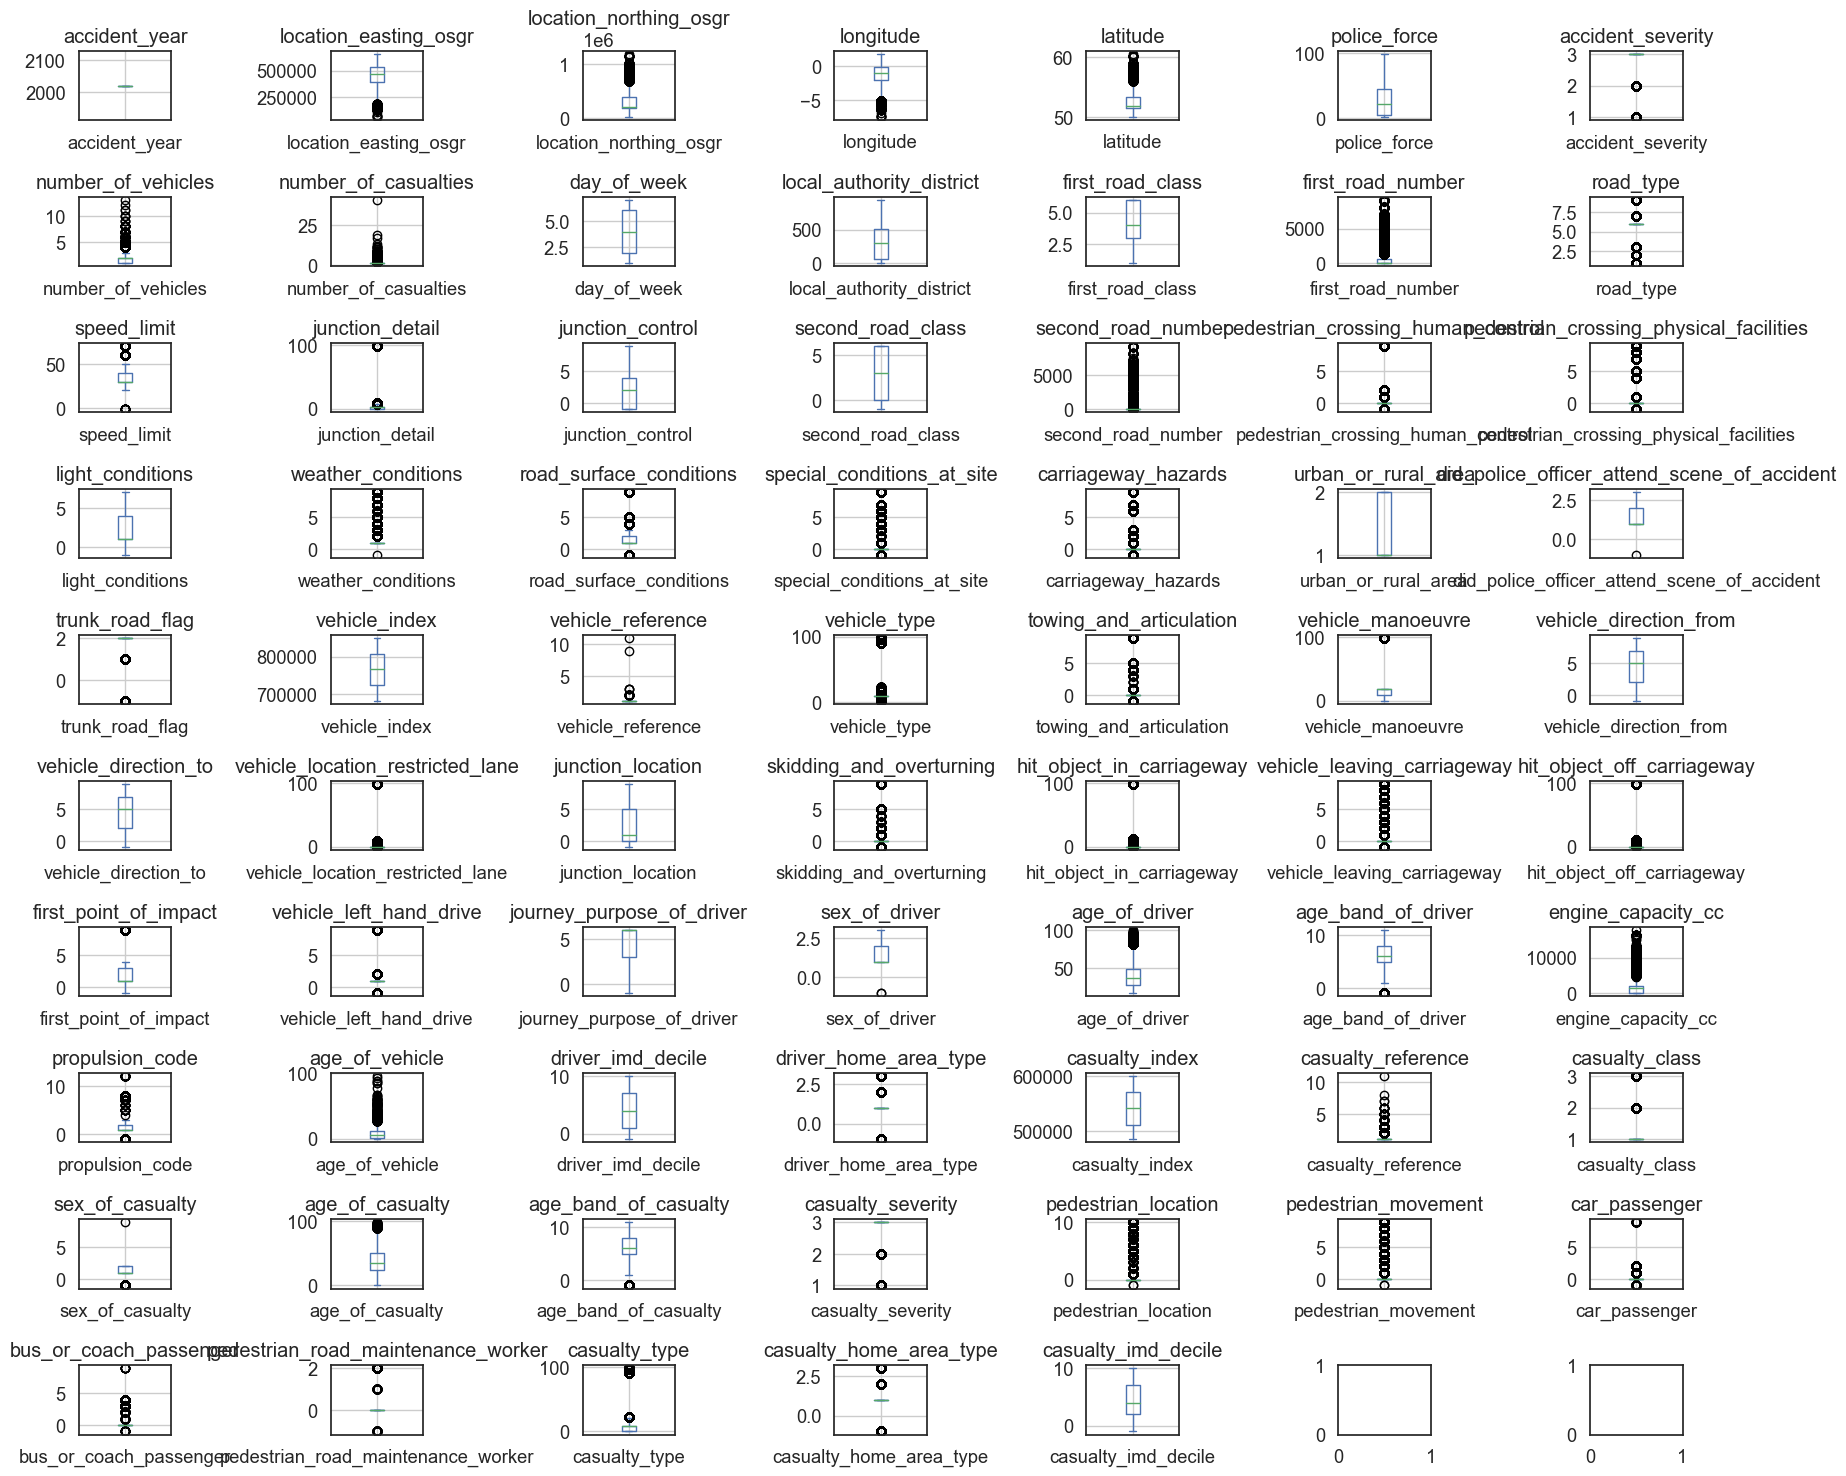

In [65]:
# Create a 6 by 7 subplot layout for box plots
fig, axes = plt.subplots(nrows=10, ncols=7, figsize=(18, 15))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each column and create a box plot in the corresponding subplot
for i, column in enumerate(df.columns):
    ax = axes[i]
    df[column].plot.box(ax=ax)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True)

# Remove empty subplots if the number of columns is less than 6 * 7
for j in range(len(df.columns), 6 * 7):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [66]:
"""
For the classification exercise, I will perform 5 different classifications the is based on 3 different datasets. The reaseon is not only to classify fatality but also to explore the effect of the -1 varaibles in the on fatality
1. first i will use all the dataset to without droping the -1 values which represents data points where the data is missing.
2. I will use the data above with variable selection to classify fatality
3. I convert all -1 values to median for continoues variables and mode for categorical variables The categorical variable to consider here is the sex type column.
4. I will do feature selection for dataset 2 and use the identified variables to classify casulaty severity """

'\nFor the classification exercise, I will perform 5 different classifications the is based on 3 different datasets. The reaseon is not only to classify fatality but also to explore the effect of the -1 varaibles in the on fatality\n1. first i will use all the dataset to without droping the -1 values which represents data points where the data is missing.\n2. I will use the data above with variable selection to classify fatality\n3. I convert all -1 values to median for continoues variables and mode for categorical variables The categorical variable to consider here is the sex type column.\n4. I will do feature selection for dataset 2 and use the identified variables to classify casulaty severity '

### Making copies of the dataset for ease of analysis

In [67]:
# Make a copy of the datafram
df_cls1 = df.copy()

# DATA PREPROCESSING FOR CLASSIFICATION

## There are some columns still in the dataset that are not relevant for the analysis succ year, vehicle_index, police_force etc. I will drop these columns because they naturally have no effect on accident outcome.  
## Also i will drop the casualty_severity column because it shares similar values with the accident_severity table and can force the model to overfit

In [68]:
# Dropping the irrelevant columns

df_cls1= df_cls1.drop(["accident_year", "police_force","casualty_severity","vehicle_index", "vehicle_reference", "casualty_index", "casualty_reference", "did_police_officer_attend_scene_of_accident"], axis='columns')



## Defining a function that converts the target variable "accident_severity" to a boolean value of non_fatal or Fatal and applying it to the accident_casualty severity column

In [69]:
def convert_to_bool(column):
    return ["Fatal" if val == 1 else "Non_fatal" for val in column]


# applying the function to the casualty_severity column
df_cls1["accident_severity"] = convert_to_bool(df_cls1["accident_severity"])

# Checking the unique values in the casualty_severity class now
df_cls1["accident_severity"].unique()

array(['Non_fatal', 'Fatal'], dtype=object)

## Plotting the distribution of accident based on the accident_severity

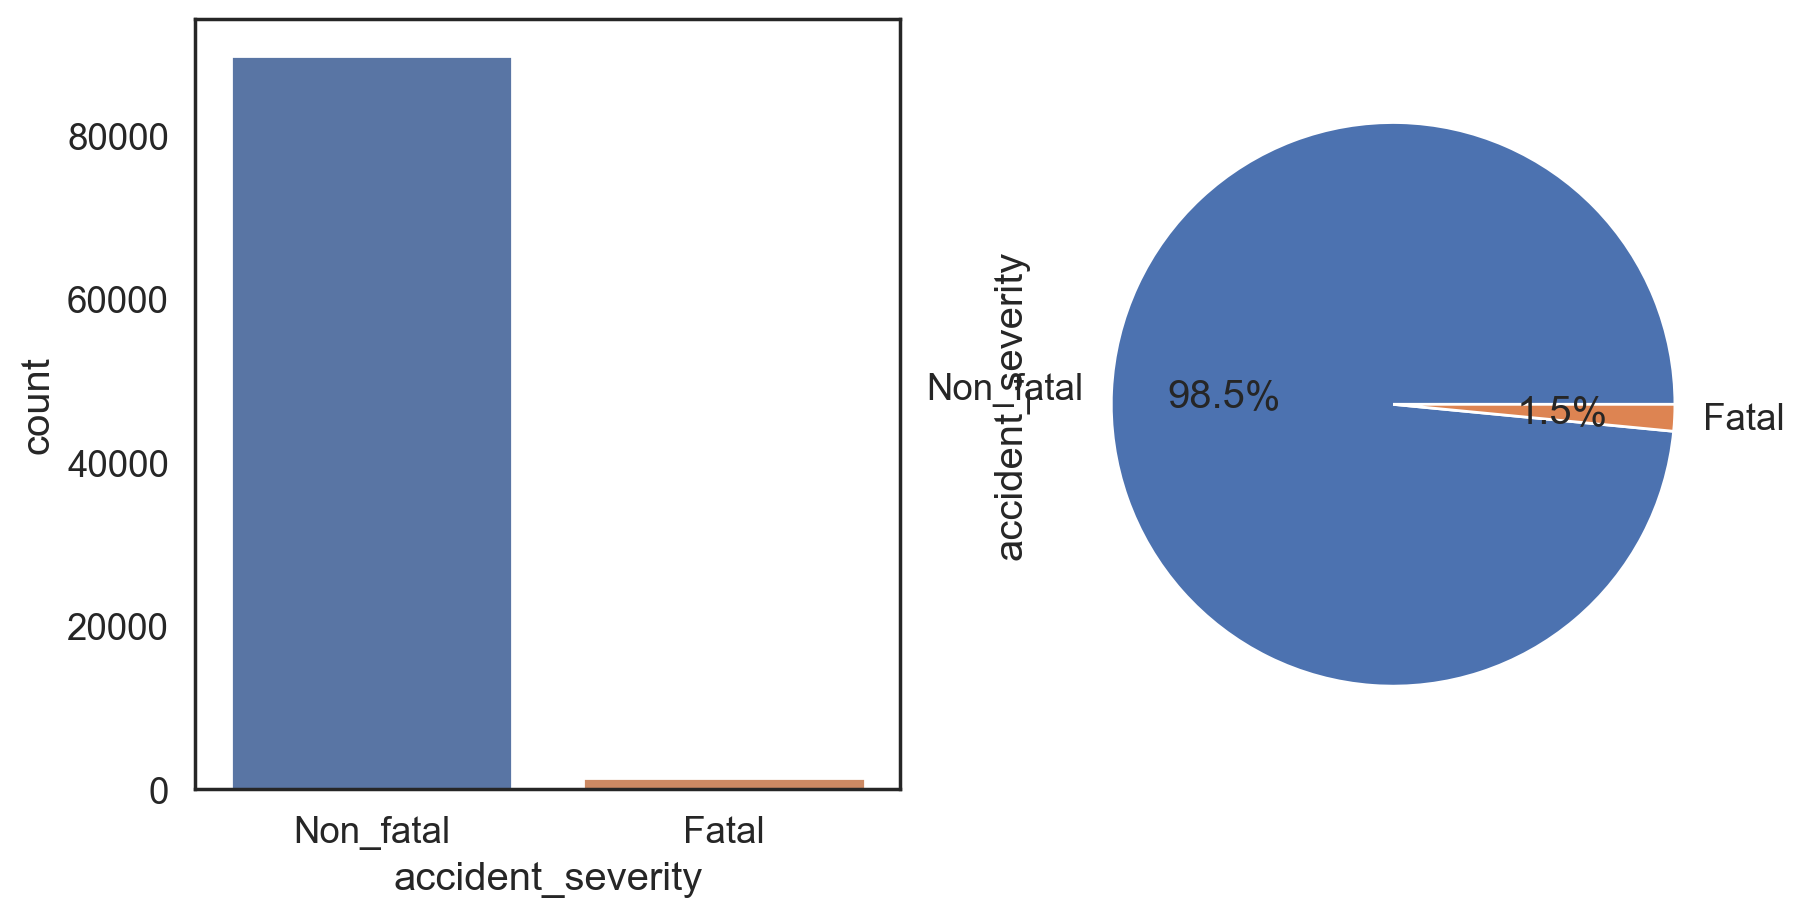

In [70]:
fig, ax_position=plt.subplots(1,2,figsize=(10,5),dpi=200) # creates the framework for th
a = sns.countplot(x = "accident_severity", data = df_cls1, ax=ax_position[0]) #ax_position[0] spe
a = df_cls1["accident_severity"].value_counts().plot.pie(autopct="%1.1f%%", ax=ax_position[1])
plt.savefig("accident_severity.png")

## From the above, we can only use random undersampler because the different in values count of fatality and others is very lange more than 30% and using oversampler will make the model to always overfit

## FIRST CLASSIFICATION: Using the Entire dataset without removing the -1 values
## For this classification I used RandomUnderSampler

In [71]:
# Preprocessing the dataset by creating X and Y variables
X =df_cls1.drop("accident_severity", axis=1)
y= df_cls1["accident_severity"]
# Performing SMOTE analysis


y.value_counts(normalize =True)
X_balanced, y_balanced = RandomUnderSampler().fit_resample(X, y)

# Checking the values of the balanced y_target variable
print(y_balanced.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state = 0)

Fatal        1391
Non_fatal    1391
Name: accident_severity, dtype: int64


## Classification: Defining a stacking classification using 4 classifiers

In [72]:
def evaluate_stacking(X, y):
    def get_stacking():
            level0 = []
            level0.append(("dtree", DecisionTreeClassifier()))
            level0.append(("knn", KNeighborsClassifier()))
            level0.append(("bayes", GaussianNB()))
            level0.append(("rfc", RandomForestClassifier()))
            level1 = LogisticRegression()

            model = StackingClassifier(estimators = level0, final_estimator = level1, cv=5)
            return model
    
    def evaluate_model(model, X, y):
            cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=24)
            scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, error_score='raise')
            return scores
    def get_models():
            models=dict()
            models['dtree']= DecisionTreeClassifier()
            models['knn']= KNeighborsClassifier()
            models['bayes']= GaussianNB()
            models["rfc"] = RandomForestClassifier()
            models["stacking"] = get_stacking()
            return models
    models=get_models()
    models



    names=[]
    results=[]
    for name, model in models.items():
            scores= evaluate_model(model, X_train, y_train)
            names.append(name)
            print(f"{name}:{mean(scores):3.2f}, {std(scores):4.3f}")


## Calling the "evaluate_stacking" function on the X_train and y_trian

In [73]:
# Calling the model
evaluation_results = evaluate_stacking(X_train, y_train)
print(evaluation_results)

dtree:0.66, 0.037
knn:0.58, 0.033
bayes:0.54, 0.019
rfc:0.75, 0.027
stacking:0.75, 0.023
None


## From the above, it is clear that the model best classification algorithm is the Random_forest_classifier. I will use the RandomForestClassifier to evaluate the classification.

## Defining a function using RandomForestClassifier to evaluate the model performance of our classification model

In [74]:


def train_and_evaluate_DT(X_train, X_test, y_train, y_test, plot_title):
   
    
    
    # Initialize the DecisionTree Classifier
    rfc = RandomForestClassifier()
    
    # Training using the DecisionTree Classifier
    rfc.fit(X_train, y_train)
    
    # Making predictions using the DecisionTree Classifier
    rfc_pred = rfc.predict(X_test)
    
    # Calculate accuracy of the  classification
    accuracy = accuracy_score(y_test, rfc_pred)
    print(F"Accuracy is {accuracy}")

    # Calculate balanced accuracy of the classification
    balanced_accuracy = balanced_accuracy_score(y_test, rfc_pred)
    print(F"Balanced_accuracy is {balanced_accuracy}")
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_test, rfc_pred))
    
    # Print confusion matrix
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, rfc_pred)
    
    
   # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - " + plot_title)  # Add the title to the plot title
    plt.savefig(f"{plot_title.replace(' ', '_')}_Confusion_Matrix.png")
    plt.show()



Accuracy is 0.7809694793536804
Balanced_accuracy is 0.7781855776686482
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.77      0.84      0.80       292
   Non_fatal       0.80      0.72      0.76       265

    accuracy                           0.78       557
   macro avg       0.78      0.78      0.78       557
weighted avg       0.78      0.78      0.78       557

Confusion Matrix:


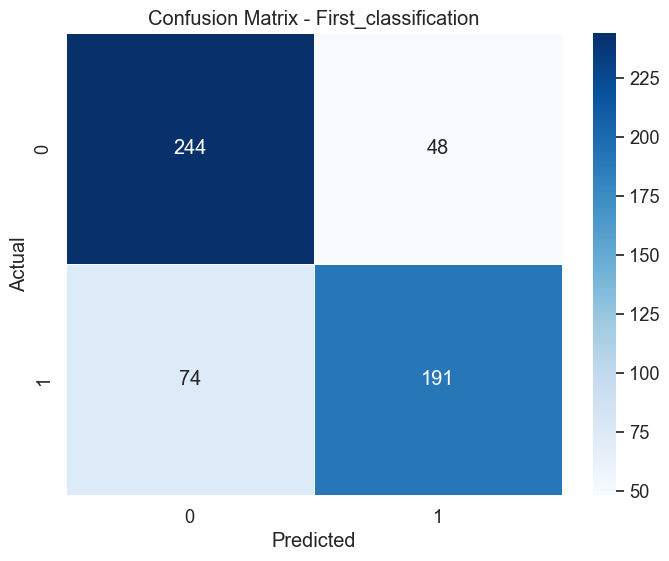

In [75]:
# Calling the evaluation function and passing the dataset through it
train_and_evaluate_DT(X_train, X_test, y_train, y_test, "First_classification")

 ## SECOND CLASSIFICATION MODEL. I performed variable selection on the dataset for the first 10 variables that best explains the target variable

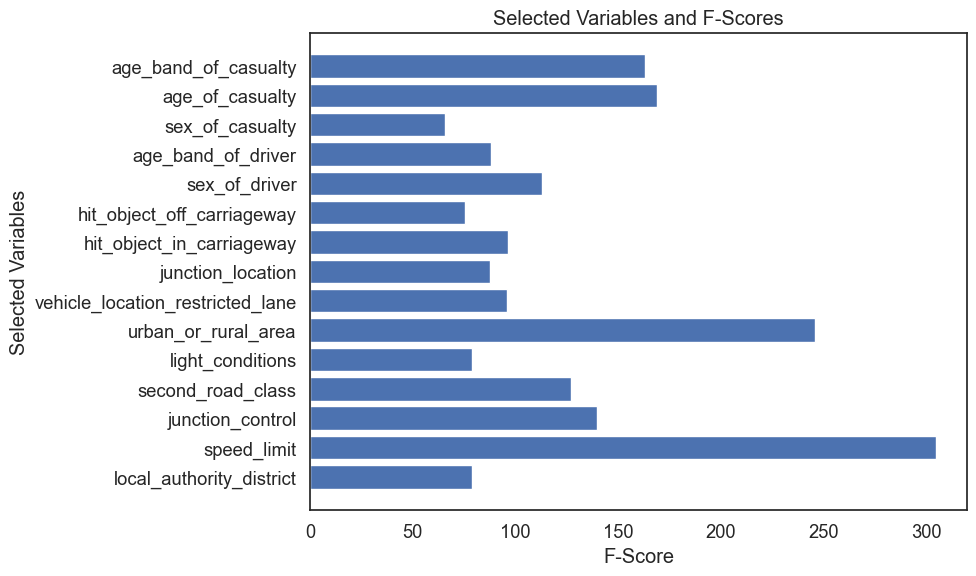

In [76]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_balanced, y_balanced)

# Defining the parameter of the selected variables and storing their names
mask = selector.get_support()
names =selector.feature_names_in_[mask]
scores = selector.scores_[mask]


# Plotting the selected variables
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.barh(names, scores)  # Horizontal bar plot
plt.xlabel('F-Score')
plt.ylabel('Selected Variables')
plt.title('Selected Variables and F-Scores')
plt.tight_layout()  # Ensure labels and titles are not cut off
plt.savefig("variable_selection1.png")
plt.show()

In [77]:
names

array(['local_authority_district', 'speed_limit', 'junction_control',
       'second_road_class', 'light_conditions', 'urban_or_rural_area',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'sex_of_driver', 'age_band_of_driver', 'sex_of_casualty',
       'age_of_casualty', 'age_band_of_casualty'], dtype=object)

In [78]:
cols = ['local_authority_district', 'speed_limit', 'junction_control',
       'second_road_class', 'urban_or_rural_area',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'sex_of_driver', 'age_of_driver', 'age_band_of_driver',
       'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty']

## Using the selected variables variables for variable selection to train the model

In [79]:
# Extrating the variables from variable selection for the new classification dataset. Note the target value remains the same
X_balanced_1 = X_balanced[cols]
#  Splitting the n
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_balanced_1, y_balanced, test_size=0.2, random_state = 0)

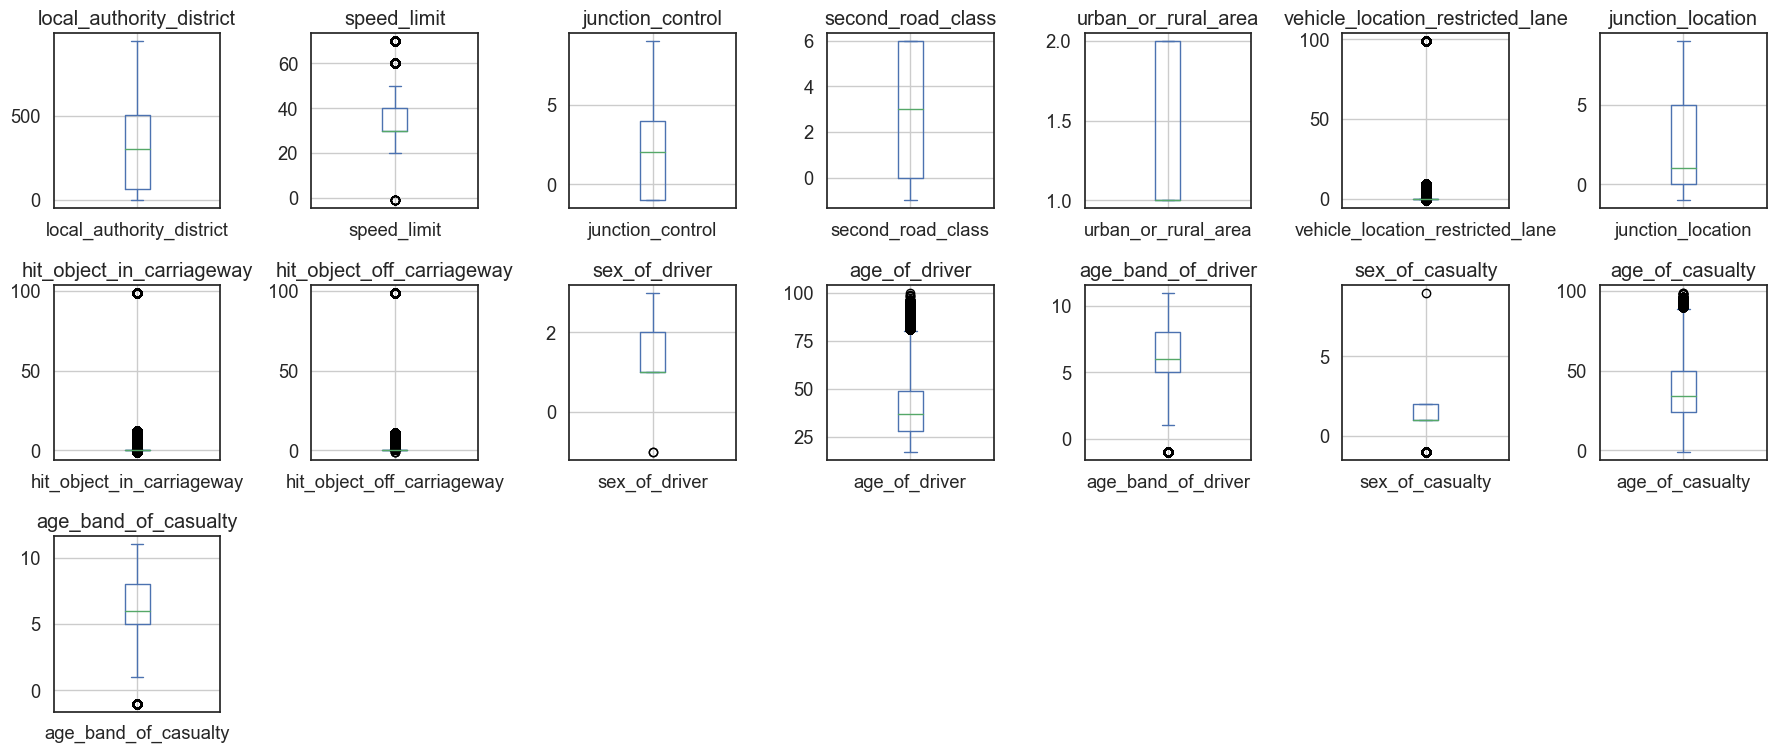

In [80]:
# Create a 6 by 7 subplot layout for box plots
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(18, 15))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each column and create a box plot in the corresponding subplot
for i, column in enumerate(X_balanced_1.columns):
    ax = axes[i]
    df[column].plot.box(ax=ax)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True)

# Remove empty subplots if the number of columns is less than 6 * 7
for j in range(len(X_balanced_1.columns), 6 * 7):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Accuracy is 0.696588868940754
Balanced_accuracy is 0.6966593434996122
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.72      0.70      0.71       292
   Non_fatal       0.68      0.70      0.69       265

    accuracy                           0.70       557
   macro avg       0.70      0.70      0.70       557
weighted avg       0.70      0.70      0.70       557

Confusion Matrix:


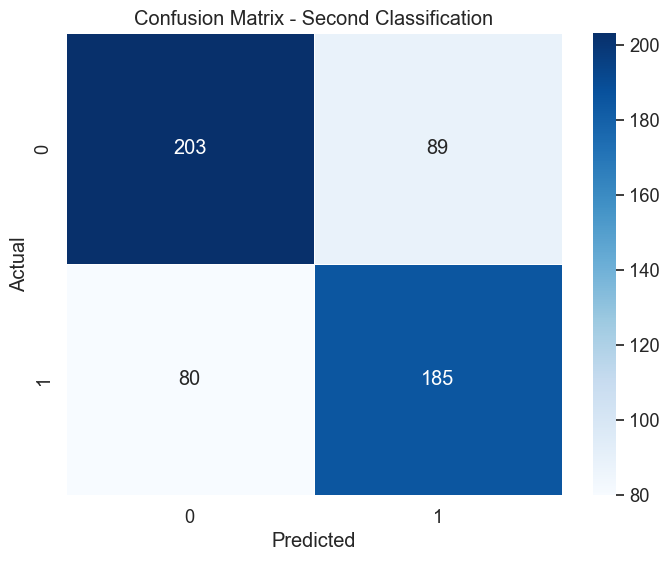

In [81]:
# Calling the second model validation
train_and_evaluate_DT(X_train1, X_test1, y_train1, y_test1, "Second Classification")

# For the 3rd and 4th Classifications, i will replace convert all the -1 Values in the dataframe to NAN and then converting all NAN values to median for continous variables and mode for categorical values like sex related columns

In [82]:
# Making a copy of the dataset for the 3rd and 4th classification
df_cls2 = df_cls1.copy()

## Converting the sex columns to either "M" for Male and "F" for female

In [83]:
def age_bool(column):
    return ["M" if val == 1 else "F" if val == 2 else np.nan for val in column]

df_cls2["sex_of_casualty"] = age_bool(df_cls2["sex_of_casualty"])
print(df_cls2["sex_of_casualty"].unique())

df_cls2["sex_of_driver"] = age_bool(df_cls2["sex_of_driver"])
print(df_cls2["sex_of_driver"].unique())

['M' 'F' nan]
['F' 'M' nan]


## Defining a function that converts the -1 to nana in the dataframe and passing the dataframe through the function

In [84]:
#Defining the function
def neg1_to_nan(dataframe):
    return dataframe.replace(-1, np.nan)
# Passing the dataFrame to the function
df_cls2 = neg1_to_nan(df_cls2)
 # Checking for any remaining missing values
df_cls2.isna().sum()

location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
latitude                                       0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
local_authority_district                     985
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                   12
junction_detail                                2
junction_control                           38292
second_road_class                            110
second_road_number                         38039
pedestrian_crossing_human_control            143
pedestrian_crossing_physical_facilities      135
light_conditions                               1
weather_conditions  

## This function that converts the NAN values to median for continous variable and mode for categorical variables

In [85]:
# Defining the function for this reconvertion
def nan_to_median_and_mode(dataframe):
    numerical_cols = dataframe.select_dtypes(include=[np.number]).columns
    categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns

    # Fill NaN in numerical columns with median
    for col in numerical_cols:
        median_val = dataframe[col].median()
        dataframe[col].fillna(median_val, inplace=True)

    # Fill NaN in categorical columns with mode
    for col in categorical_cols:
        mode_val = dataframe[col].mode().iloc[0]
        dataframe[col].fillna(mode_val, inplace=True)

### Calling the "nan_to_median_and_mode" function

In [86]:
## Applying the function to the dataframe
nan_to_median_and_mode(df_cls2)

# Checking to confirm there are no more NAN values
df_cls2.isna().sum()

location_easting_osgr                      0
location_northing_osgr                     0
longitude                                  0
latitude                                   0
accident_severity                          0
number_of_vehicles                         0
number_of_casualties                       0
day_of_week                                0
local_authority_district                   0
first_road_class                           0
first_road_number                          0
road_type                                  0
speed_limit                                0
junction_detail                            0
junction_control                           0
second_road_class                          0
second_road_number                         0
pedestrian_crossing_human_control          0
pedestrian_crossing_physical_facilities    0
light_conditions                           0
weather_conditions                         0
road_surface_conditions                    0
special_co

### Reconverting the sex_related columns to numerical values that have only 1 and 2 representing male and female

In [87]:
# Defining the function for this
def convert_sexCol_1_2(column):
    # Define a mapping dictionary
    bool_mapping = {"M": 1, "F": 2}

    # Apply the mapping to the column using map
    return column.map(bool_mapping)

## Mapping the function to the respective sex columns
df_cls2["sex_of_casualty"] = convert_sexCol_1_2(df_cls2["sex_of_casualty"])
df_cls2["sex_of_driver"] = convert_sexCol_1_2(df_cls2["sex_of_driver"])

# Confirming the new sex values
df_cls2["sex_of_casualty"].unique()

array([1, 2], dtype=int64)

# THIRD CLASSSIFICATION MODEL: Using the neew dataframe where the median andmode has been used to replace the -1 values

In [88]:
# Preprocessing the dataset by creating X and Y variables
X =df_cls2.drop("accident_severity", axis=1)
y= df_cls2["accident_severity"]
# Performing SMOTE analysis


y.value_counts(normalize =True)
X_balanced3, y_balanced3 = RandomUnderSampler().fit_resample(X, y)

# Checking the values of the balanced y_target variable
y_balanced3.value_counts()

Fatal        1391
Non_fatal    1391
Name: accident_severity, dtype: int64

Accuracy is 0.7881508078994613
Balanced_accuracy is 0.7859072111656759
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.78      0.83      0.80       292
   Non_fatal       0.80      0.74      0.77       265

    accuracy                           0.79       557
   macro avg       0.79      0.79      0.79       557
weighted avg       0.79      0.79      0.79       557

Confusion Matrix:


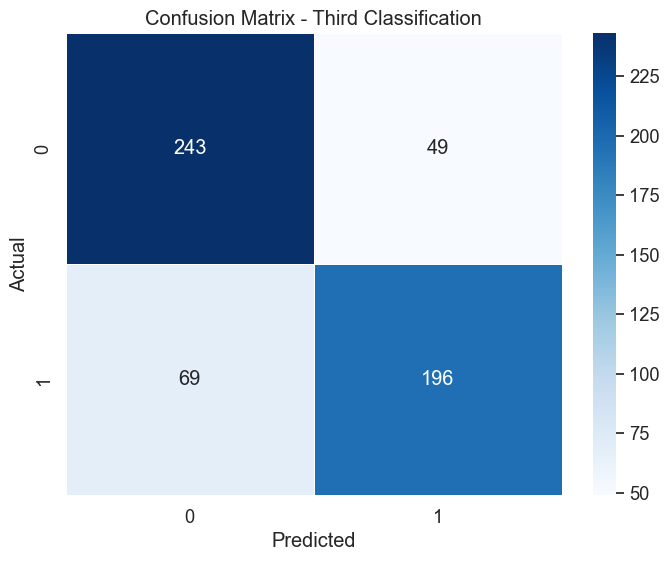

In [89]:
# Splitting the new dataframe into the train and test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_balanced3, y_balanced3, test_size=0.2, random_state = 0)

# Passing the variables through "the train_and_evaluate_DT" function
train_and_evaluate_DT(X_train2, X_test2, y_train2, y_test2, "Third Classification")


# FOURTH CLASSIFICATION MODEL: Performing varaible selection on the new dataset 

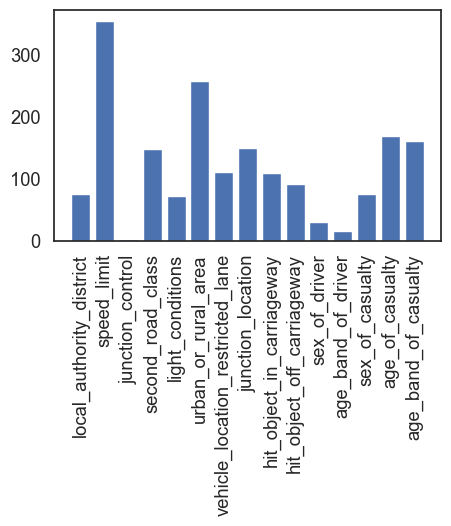

In [90]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_balanced3, y_balanced3)

# Defining the parameter of the selected variables and storing their names
mask1 = selector.get_support()
names1 =selector.feature_names_in_[mask]
scores1 = selector.scores_[mask]


# Plotting the selected variables
plt.bar(names, scores1)
plt.xticks(rotation ='vertical')
plt.savefig("variable_selection2.png")

In [91]:
names1

array(['local_authority_district', 'speed_limit', 'junction_control',
       'second_road_class', 'light_conditions', 'urban_or_rural_area',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'sex_of_driver', 'age_band_of_driver', 'sex_of_casualty',
       'age_of_casualty', 'age_band_of_casualty'], dtype=object)

In [92]:
cols1 = ['local_authority_district', 'speed_limit', 'junction_control',
       'second_road_class', 'urban_or_rural_area',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'sex_of_driver', 'age_of_driver', 'age_band_of_driver',
       'driver_home_area_type', 'age_of_casualty', 'age_band_of_casualty']

In [93]:
# Subsetting the new dataset uisng the select variables form variable selection
X_balanced4 = X_balanced3[cols1]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_balanced4, y_balanced3, test_size=0.2, random_state = 0)

Accuracy is 0.696588868940754
Balanced_accuracy is 0.6961359524424916
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.71      0.71      0.71       292
   Non_fatal       0.68      0.69      0.68       265

    accuracy                           0.70       557
   macro avg       0.70      0.70      0.70       557
weighted avg       0.70      0.70      0.70       557

Confusion Matrix:


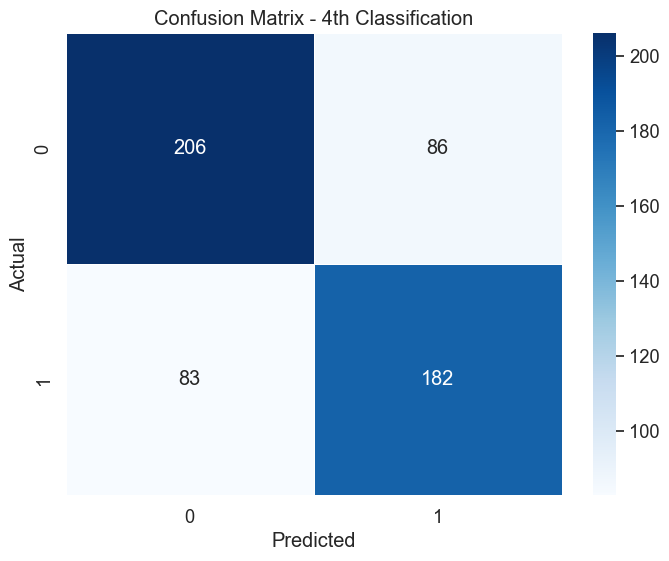

In [94]:
# The classification function on the new train_test_split dataset
train_and_evaluate_DT(X_train3, X_test3, y_train3, y_test3, "4th Classification")

##  Closing connection to my database ()

In [95]:
con.close()